In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from os.path import join
import Pk_library as PKL
os.chdir('/home/mattho/git/ltu-cmass/matts_tests')
mpl.style.use('./style.mcstyle')


## Test ltu-cmass

In [6]:
lhid = 3
wdir = '/home/mattho/git/ltu-cmass/data/'
cdir = wdir+f'charm_1gpch_z0.5/borgpm/L1000-N128/{lhid}'
qdir = wdir+f'quijote/latin_hypercube_HR/L1000-N128/{lhid}'
os.listdir(cdir)

['rho.npy',
 'fvel.npy',
 'rho_z50.npy',
 'config.yaml',
 'halo_pos.npy',
 'halo_vel.npy',
 'halo_mass.npy',
 'halo_cuboid_pos.npy',
 'halo_cuboid_vel.npy',
 'hod',
 'obs',
 'Pk']

In [7]:
r = np.load(join(cdir, 'rho.npy'))
ric = np.load(join(cdir, 'rho_z50.npy'))

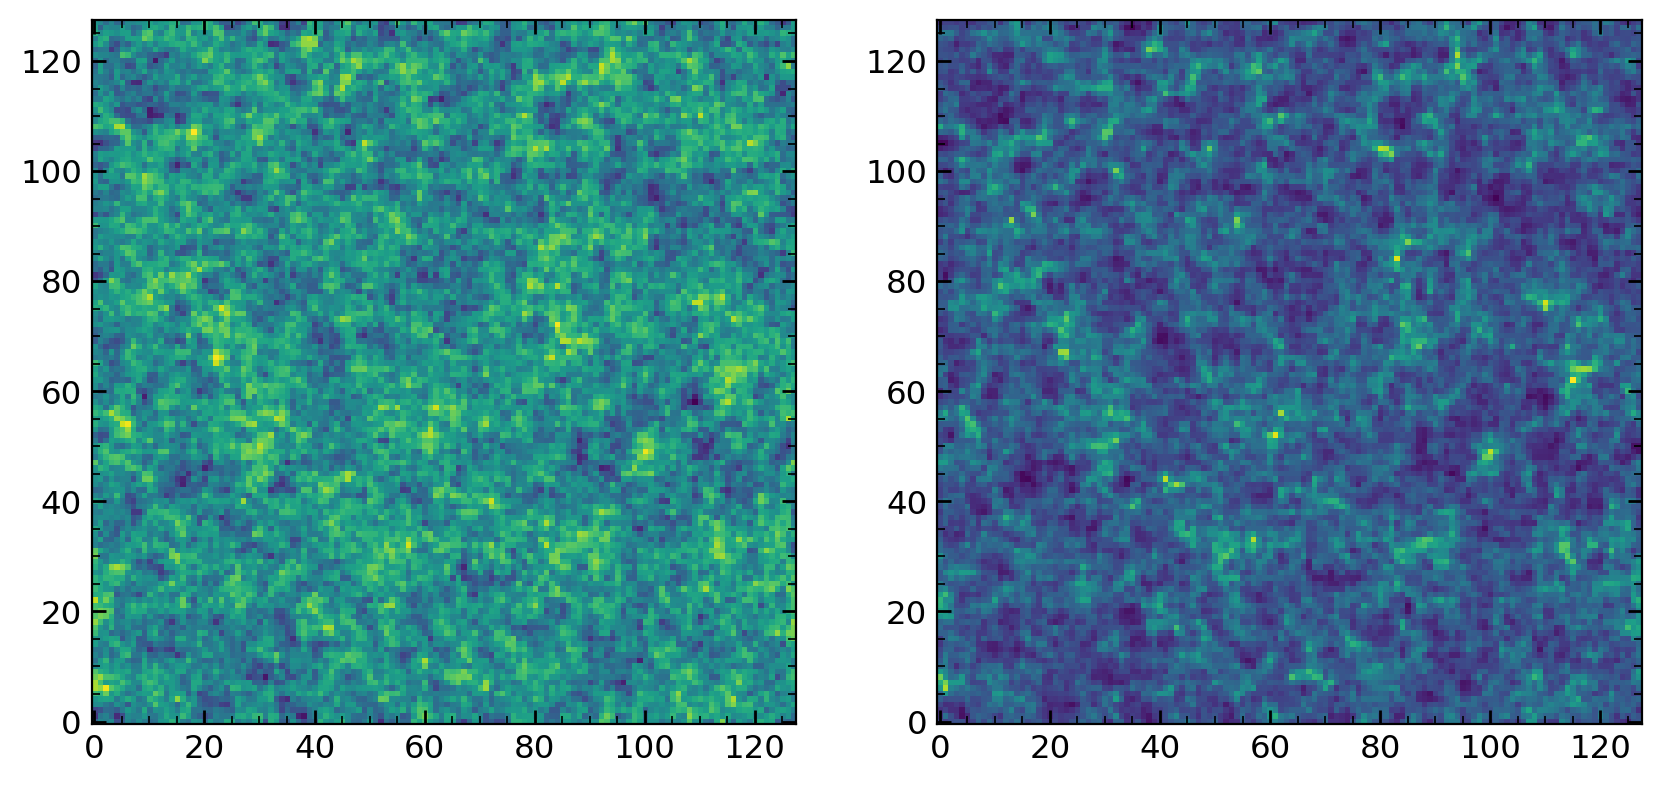

In [4]:
i, di = 90, 80

def slice_box(rho, i, di):
    return np.mean(rho[i-di//2:i+di//2], axis=0)

f, axs = plt.subplots(1,2)
axs[0].imshow(slice_box(ric, i, di))
axs[1].imshow(slice_box(r, i, di))

In [5]:
import pickle
fdir = '/home/mattho/git/ltu-cmass/data/scratch/fastpm'
filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=99_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
d.keys()

dict_keys(['density_cic_unpad_combined', 'density_cic_pad_combined'])

In [6]:
from colossus.cosmology import cosmology as csm
from cmass.utils import cosmo_to_colossus
cpars = [0.3271, 0.06875, 0.6313, 0.8135, 0.8939]

# cosmo = cosmo_to_astropy(cpars)
# cosmo = csm.fromAstropy(
#     cosmo, sigma8=cpars[4], ns=cpars[3], cosmo_name='myCosmo', Tcmb0 = 2.7255)
cosmo = cosmo_to_colossus(cpars)
corr = cosmo.growthFactorUnnormalized(z=99)
corr /= cosmo.growthFactorUnnormalized(z=50)
print(corr)

0.5152969262698477


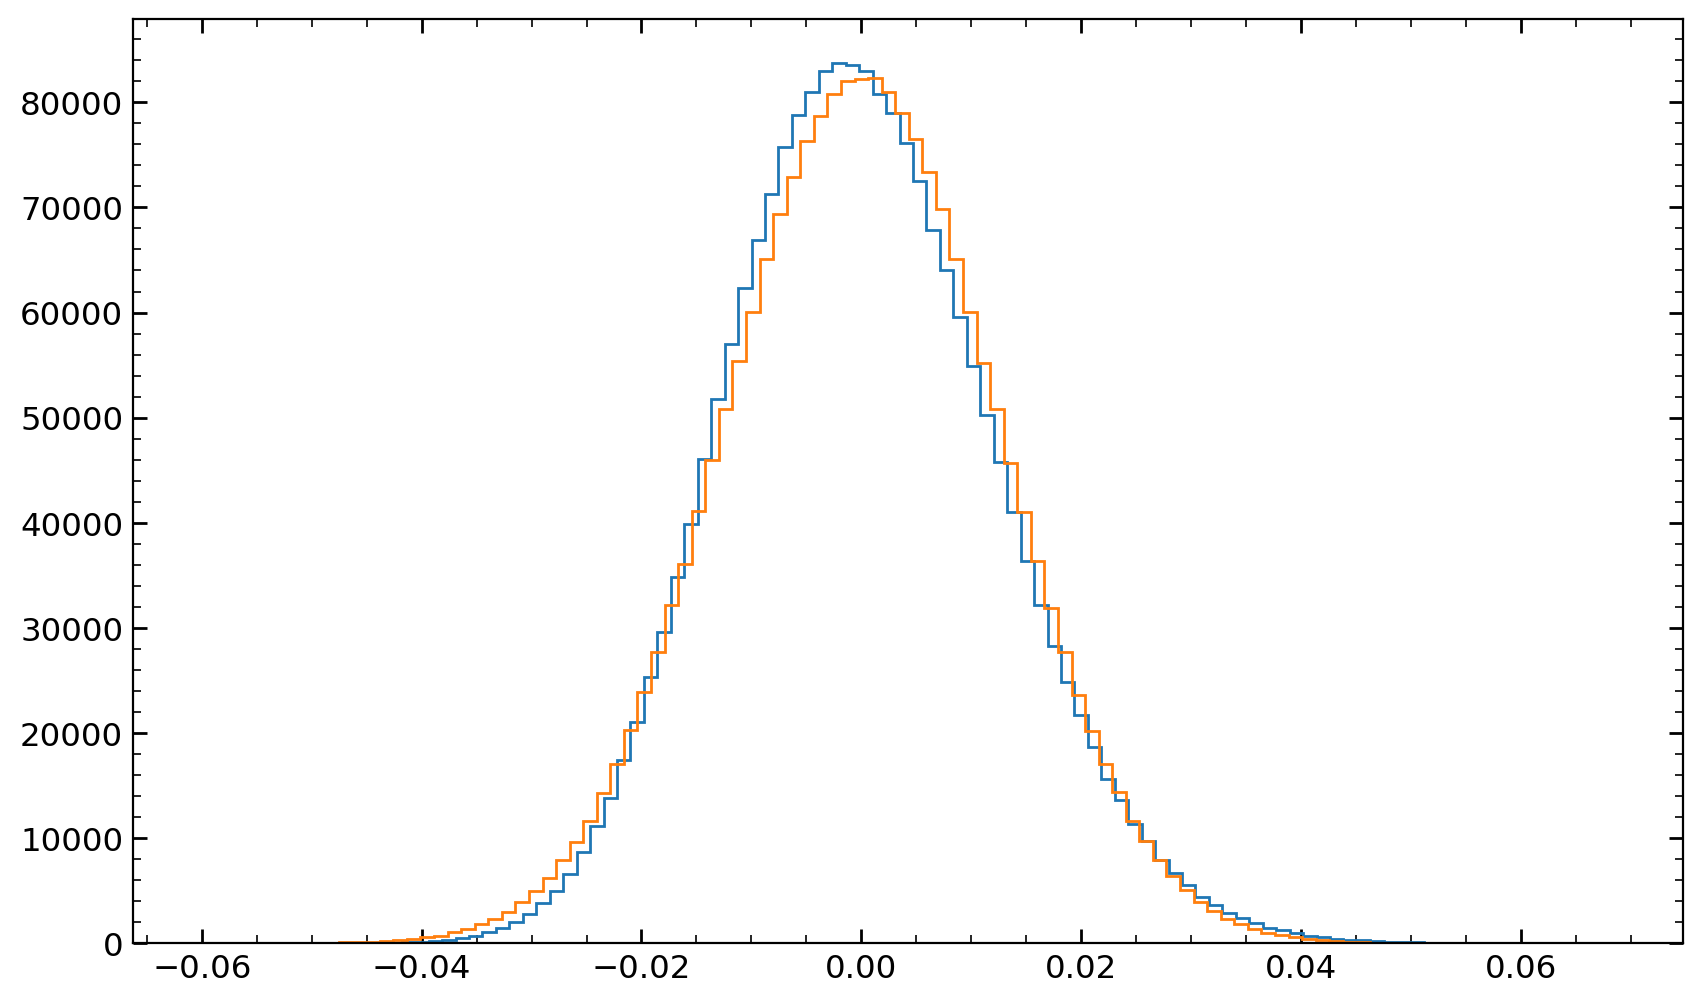

In [7]:
plt.hist(d['density_cic_unpad_combined'].flatten(), bins=100, histtype='step');
plt.hist(ric.flatten()*corr*0.72, bins=100, histtype='step');

In [8]:
hpos = np.load(join(cdir, 'halo_pos.npy'))
hmass = np.load(join(cdir, 'halo_mass.npy'))
qpos = np.load(join(qdir, 'halo_pos.npy'))
qmass = np.load(join(qdir, 'halo_mass.npy'))

mask = hmass > 13
hpos = hpos[mask]
hmass = hmass[mask]

mask = qmass > 13
qpos = qpos[mask]
qmass = qmass[mask]

(0.0, 1000.0, 0.0, 1000.0)

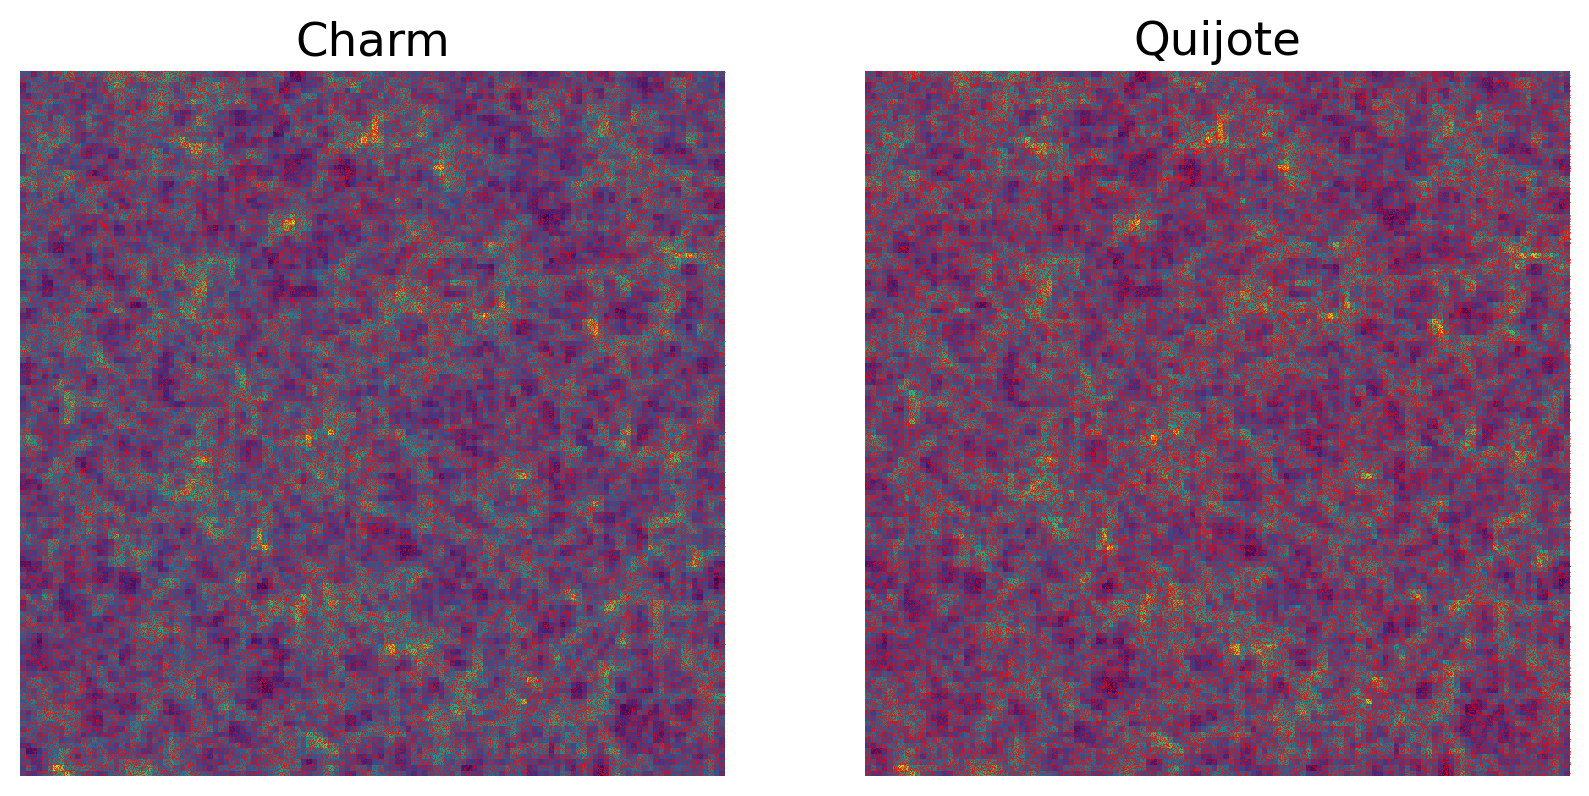

In [9]:
L, N = 1000, 128
def slice_cat(pos, i, di):
    mmin, mmax = (i-di)*L/N, (i+di)*L/N
    mask = mmin < pos[:,0]
    mask &= pos[:,0] < mmax
    return pos[mask]

fig, axs = plt.subplots(1,2,figsize=(10,6))

ax = axs[0]
ax.imshow(slice_box(r, i, di).T, 
          extent=[0,L]*2, origin='lower')
_p = slice_cat(hpos, i, di)
ax.plot(_p[:,1], _p[:,2], 'r,', alpha=0.5)
ax.set_title('Charm')
ax.axis('off')

ax = axs[1]
ax.imshow(slice_box(r, i, di).T, 
          extent=[0,L]*2, origin='lower')
_p = slice_cat(qpos, i, di)
ax.plot(_p[:,1], _p[:,2], 'r,', alpha=0.5)
ax.set_title('Quijote')
ax.axis('off')



Text(0, 0.5, 'count')

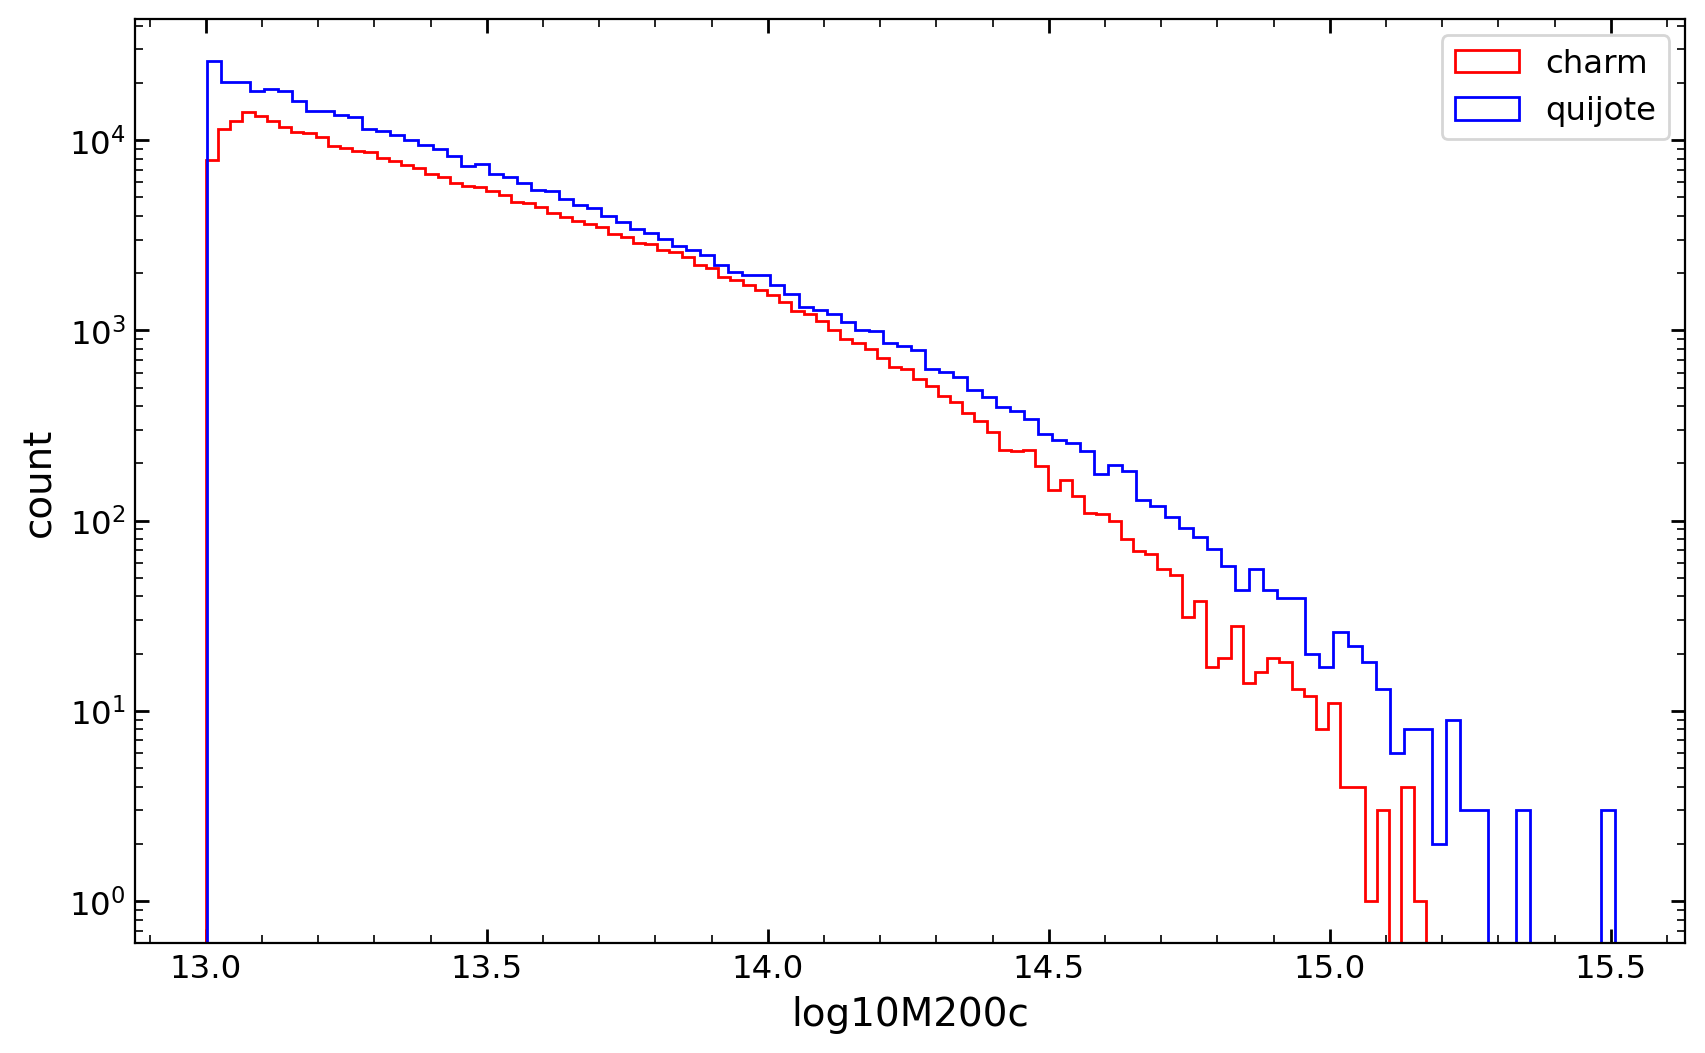

In [10]:

plt.semilogy()
plt.hist(hmass, bins=100, histtype='step', color='r', label='charm')
plt.hist(qmass, bins=100, histtype='step', color='b', label='quijote')
plt.legend()
plt.xlabel('log10M200c')
plt.ylabel('count')

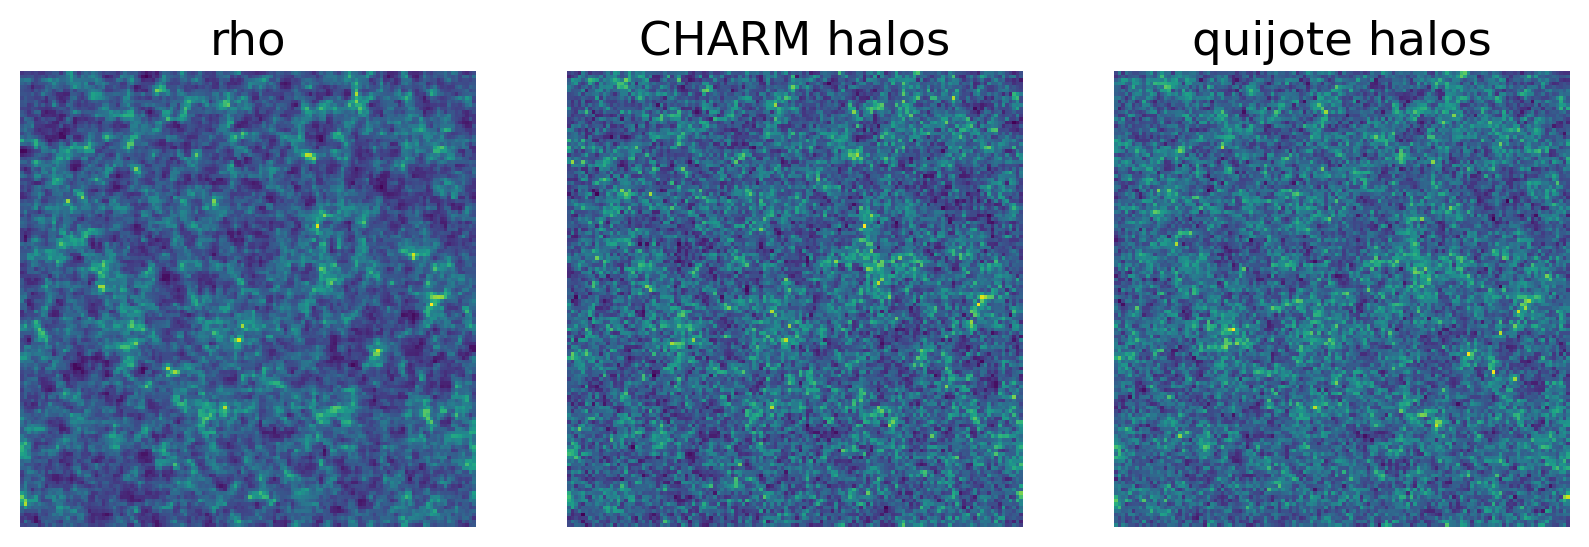

In [11]:

f, axs = plt.subplots(1,3,figsize=(10,6))

axs[0].imshow(slice_box(r, i, di))
axs[0].set_title('rho')

_p = slice_cat(hpos, i, di)
H, _, _ = np.histogram2d(_p[:,1], _p[:,2], 128)
axs[1].imshow(H)
axs[1].set_title('CHARM halos')

_p = slice_cat(qpos, i, di)
H, _, _ = np.histogram2d(_p[:,1], _p[:,2], 128)
axs[2].imshow(H)
axs[2].set_title('quijote halos')

for ax in axs:
    ax.axis('off')


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.08 seconds


Text(0, 0.5, 'XPk bias')

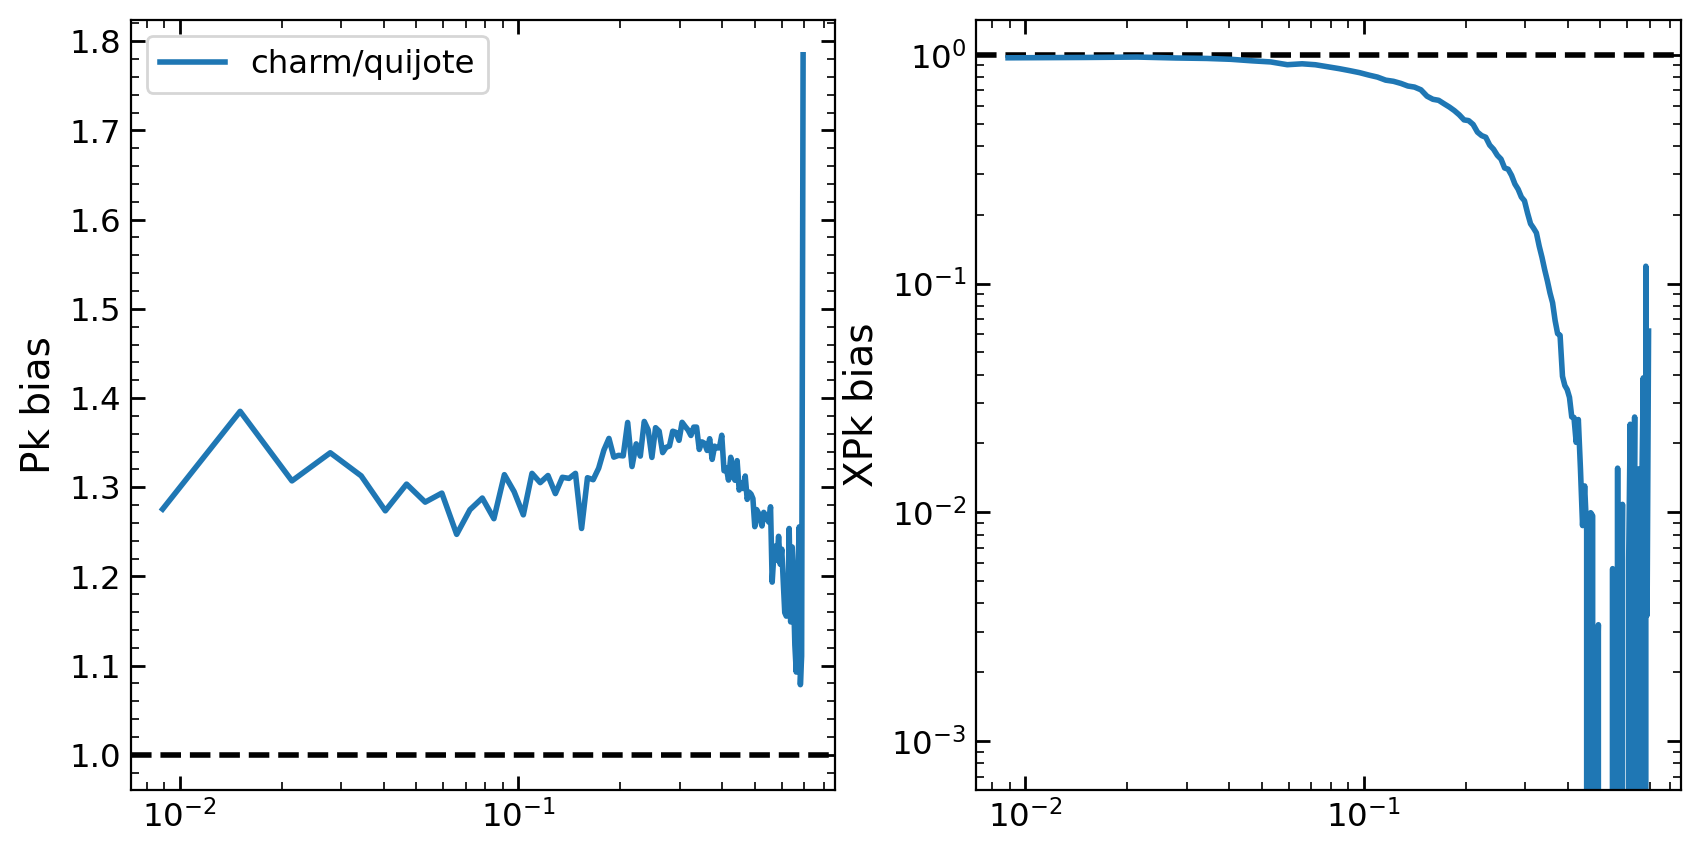

In [12]:

cH, _ = np.histogramdd(hpos, bins=128, range=[[0,1000]]*3)
qH, _ = np.histogramdd(qpos, bins=128, range=[[0,1000]]*3)
cH, qH = map(lambda x: x.astype(np.float32), [cH, qH])

cH /= cH.mean()
qH /= qH.mean()
cH -= 1
qH -= 1

Pk = PKL.XPk([cH,qH], 1000, 0, MAS=['NGP','NGP'], threads=1)

f, axs = plt.subplots(1, 2, figsize=(10,5))

# Pk
ax = axs[0]
k = Pk.k3D
ax.semilogx()
ax.axhline(1, color='k', ls='--')
ax.plot(k, Pk.Pk[:,0,0]/Pk.Pk[:,0,1], label='charm/quijote')
ax.set_ylabel('Pk bias')
ax.legend()

# XPk
ax = axs[1]
ax.loglog()
k = Pk.k3D
ax.axhline(1, color='k', ls='--')
ax.plot(k, Pk.XPk[:,0,0]/np.sqrt(Pk.Pk[:,0,0]*Pk.Pk[:,0,1]), 
        label='ltucmass-quijote')
ax.set_ylabel('XPk bias')

In [13]:
cPk = np.load(join(cdir, 'Pk', 'Pk0.npz'))
qPk = np.load(join(qdir, 'Pk', 'Pk0.npz'))

Text(0.5, 1.0, 'Survey')

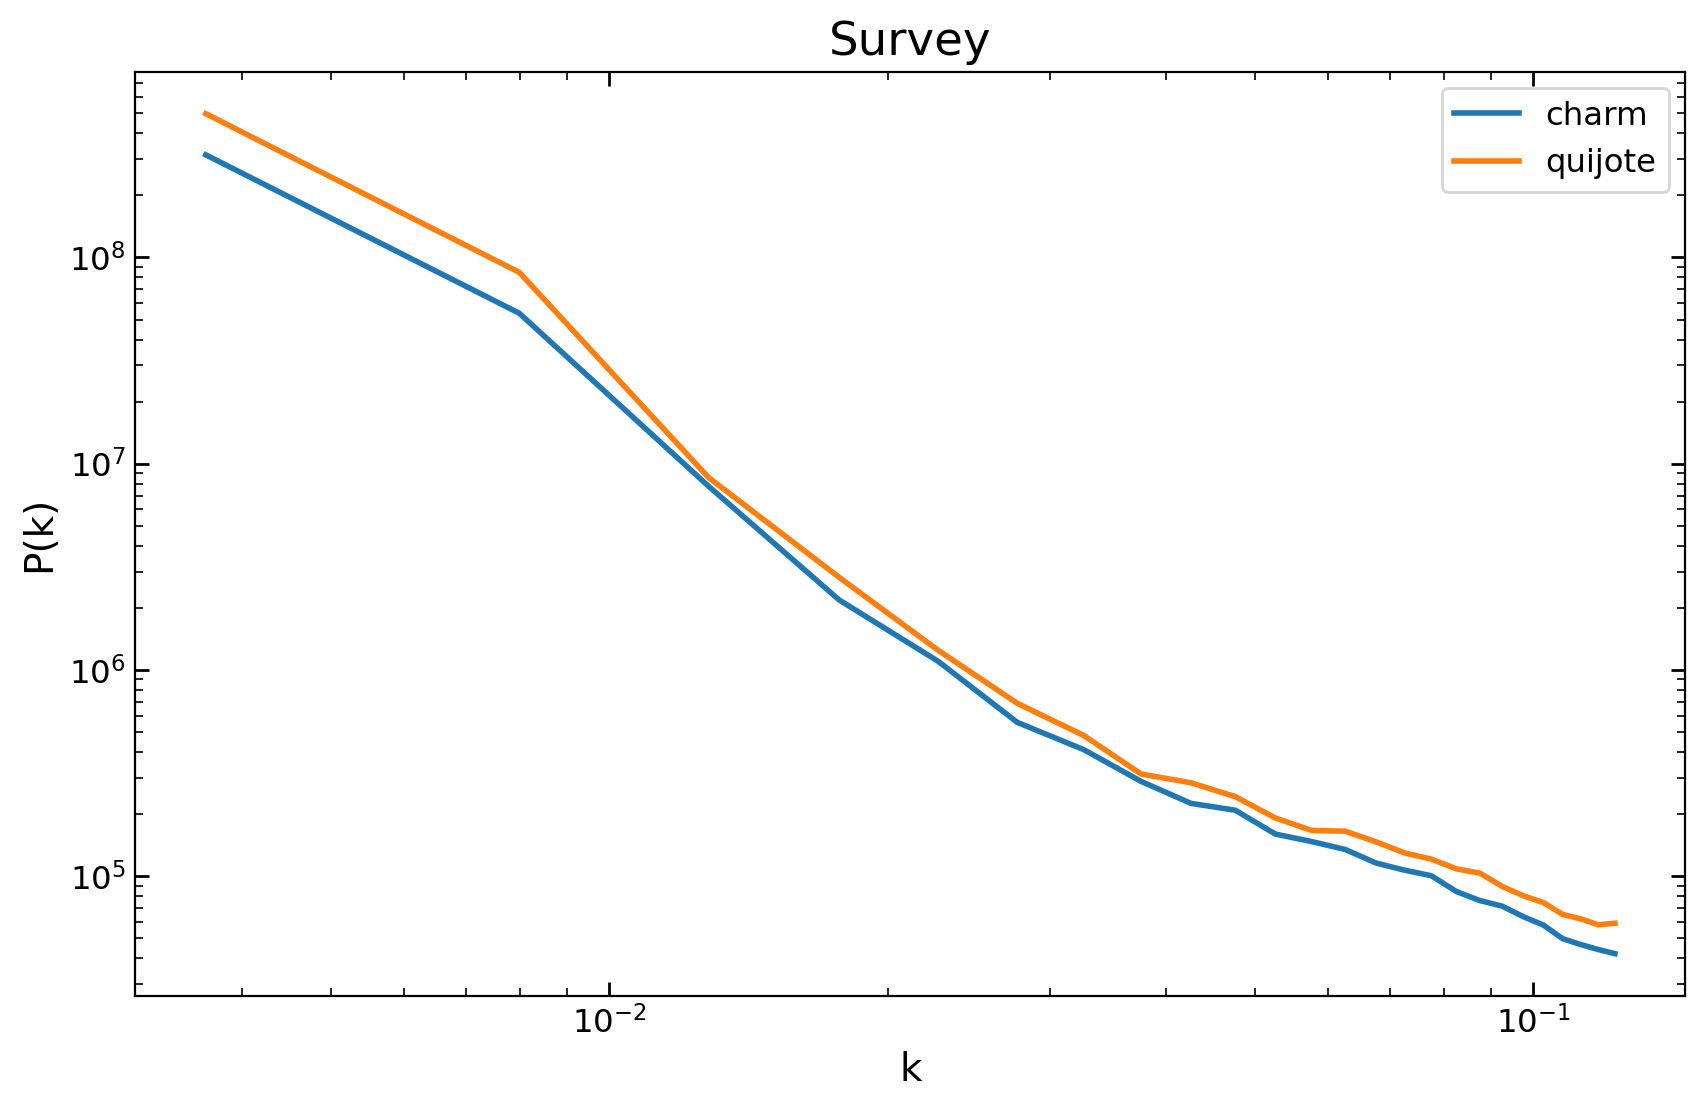

In [14]:

plt.loglog()
plt.plot(cPk['k_gal'], cPk['p0k_gal'], label='charm')
plt.plot(qPk['k_gal'], qPk['p0k_gal'], label='quijote')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.title('Survey')

## Test BORGPM vs FASTPM

In [19]:
from cmass.utils import load_params
lhid = 3
BoxSize=1000.0
wdir = '/home/mattho/git/ltu-cmass/data/'
cdir = wdir+f'test/borgpm/L1000-N128/{lhid}'
qdir = wdir+f'quijote/latin_hypercube_HR/L1000-N128/{lhid}'
cosmo = load_params(lhid, '../params/latin_hypercube_params.txt')

r = np.load(join(cdir, 'rho.npy'))
ric = np.load(join(cdir, 'rho_z50.npy'))

In [20]:
# Load FastPM

import pickle

lhid=3
fdir = '/home/mattho/git/ltu-cmass/data/scratch/fastpm'
filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=99_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rho_IC = d['density_cic_unpad_combined']

filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rho = d['density_cic_unpad_combined']
print(rho_IC.shape, rho.shape)

(128, 128, 128) (128, 128, 128)


In [21]:
# Load Quijote

snapnum = 3
isim_fid = lhid
mass_type = 'rockstar_200c'
snap_dir_base = '/home/mattho/data/quijote/Halos/Rockstar/latin_hypercube_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h


# Conform
qmass = np.log10(mass_truth)
mask = qmass > 13
qmass = qmass[mask]
qpos = pos_h_truth[mask]


/tmp/ipykernel_2668988/3432032703.py:23: RuntimeWarning: divide by zero encountered in log10
  qmass = np.log10(mass_truth)



Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


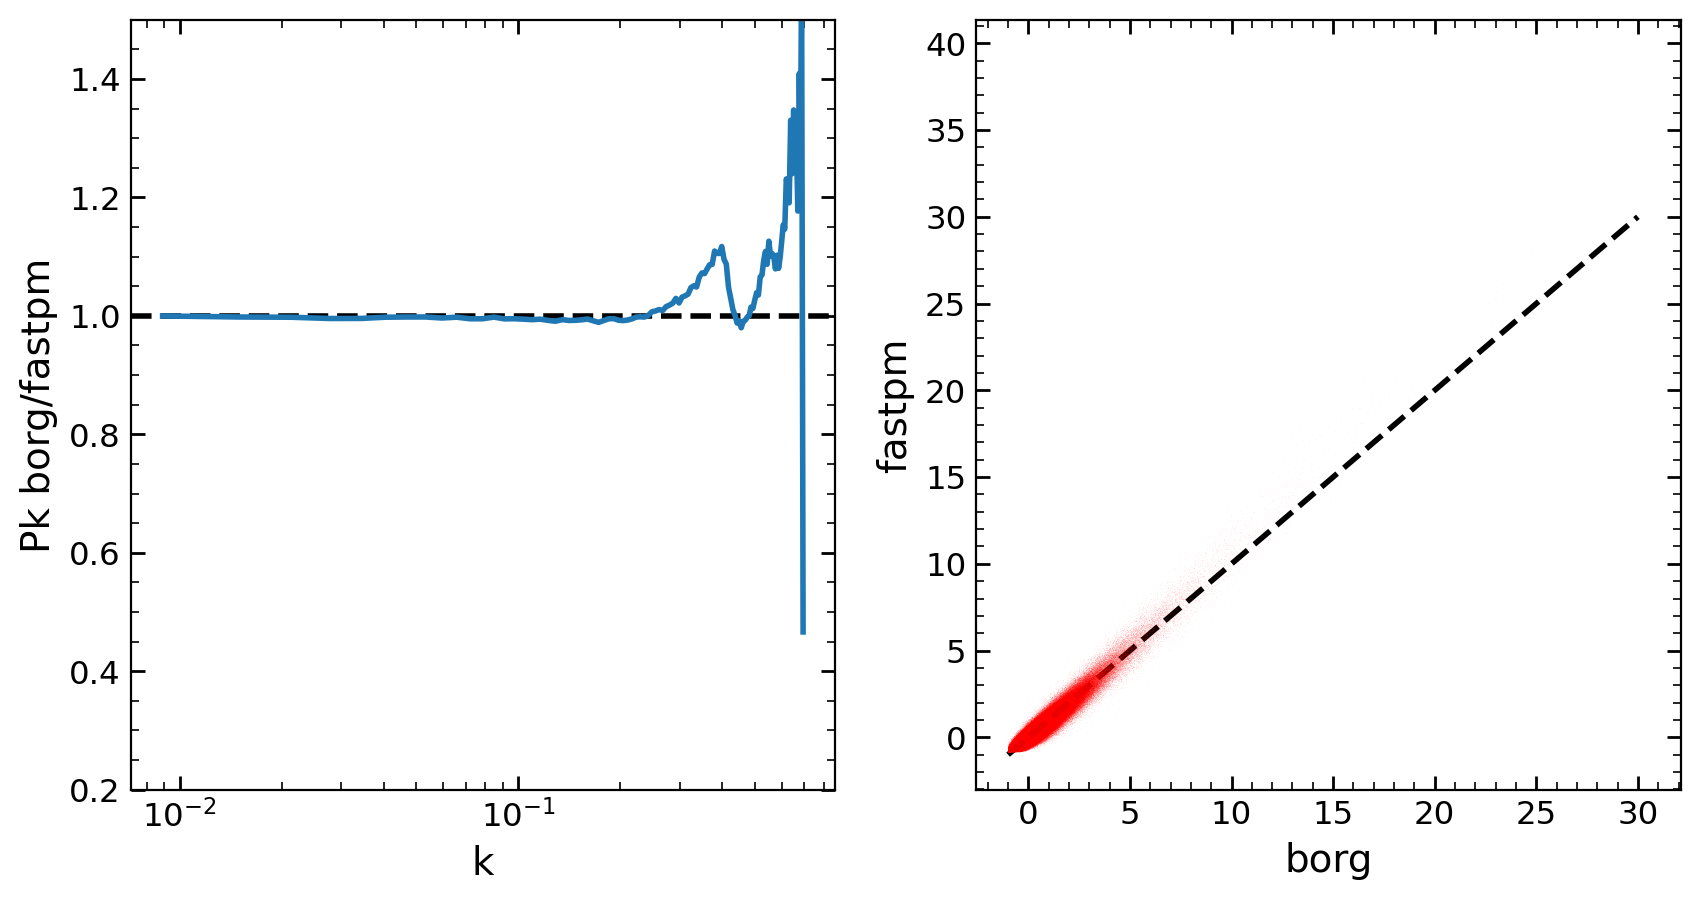

In [22]:
f, axs = plt.subplots(1,2, figsize=(10,5))

Pk_h_fastpm = PKL.Pk(rho.astype(np.float32), BoxSize, axis=0, MAS='CIC', threads=1)
Pk_h_borg = PKL.Pk(r.astype(np.float32), BoxSize, axis=0, MAS='CIC', threads=1)
axs[0].semilogx()
axs[0].axhline(1, color='k', ls='--')
axs[0].plot(Pk_h_fastpm.k3D, Pk_h_borg.Pk[:,0]/Pk_h_fastpm.Pk[:,0], label='fastpm')
axs[0].set(xlabel='k', ylabel='Pk borg/fastpm')
axs[0].set_ylim(0.2, 1.5)

x_ = np.linspace(-1,30, 100)
axs[1].plot(x_, x_, 'k--')
axs[1].plot(r.flatten(), rho.flatten(), 'r,', alpha=0.05)
axs[1].set(xlabel='borg', ylabel='fastpm');

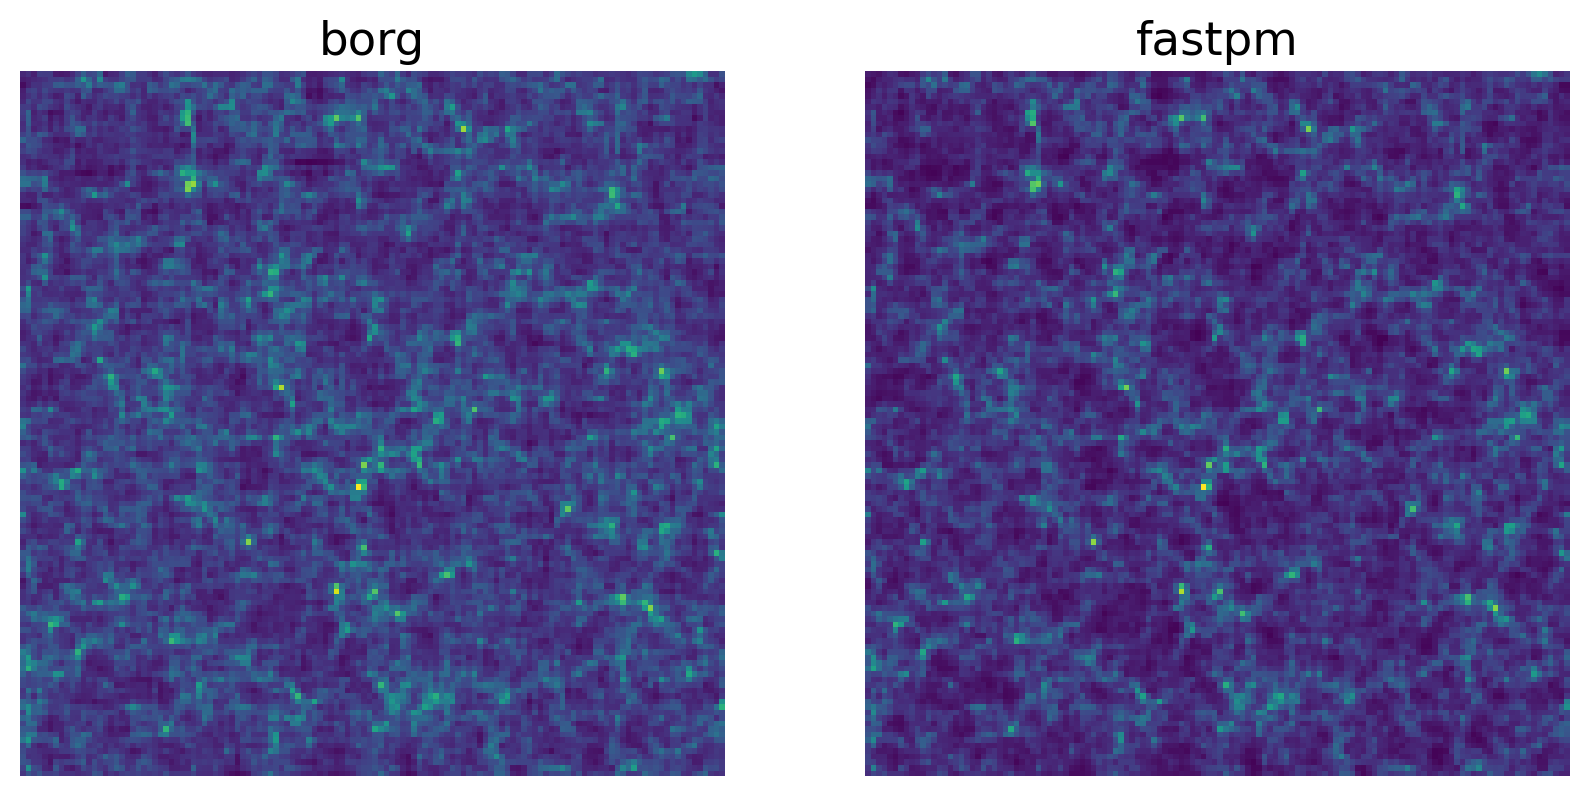

In [23]:
f, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(np.mean(r[50:60], axis=0))
axs[0].set_title('borg')
axs[1].imshow(np.mean(rho[50:60], axis=0))
axs[1].set_title('fastpm')
for ax in axs:
    ax.axis('off')

In [7]:
# Run charm

from cmass.bias.charm.integrate_ltu_cmass import get_model_interface
run_config_name = 'config_v0.yaml'
charm_interface = get_model_interface(run_config_name)

cpars = cosmo
hpos, hmass = charm_interface.process_input_density(
    r,
    ric, # ric*0.7,
    cosmology_array=np.array(cpars)
)
mask = hmass > 13
hpos = hpos[mask]
hmass = hmass[mask]

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/mattho/git/ltu-cmass/cmass/bias/charm

loading bestfit model
-34.86669921875 20278


/home/mattho/git/ltu-cmass/cmass/bias/charm/integrate_ltu_cmass.py:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df_test_all_unpad = torch.tensor(
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Computing power spectra of the fields...
Time FFTS = 0.03
Time loop = 0.05
Time taken = 0.08 seconds


Text(0, 0.5, 'Cross Power Spectrum')

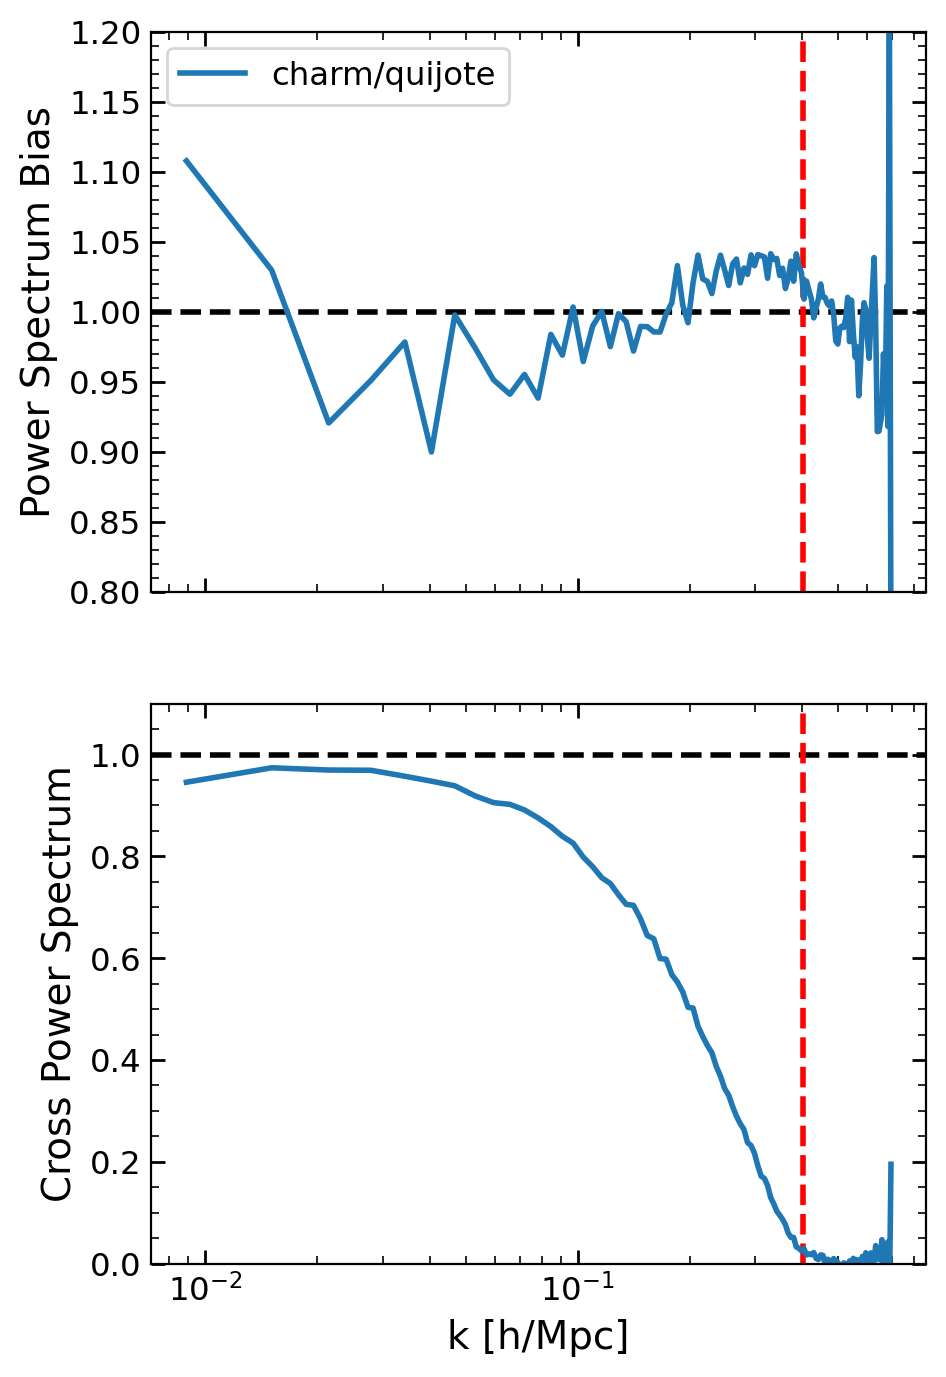

In [8]:
import Pk_library as PKL

cH, _ = np.histogramdd(hpos, bins=128, range=[[0,1000]]*3)
qH, _ = np.histogramdd(qpos, bins=128, range=[[0,1000]]*3)
cH, qH = map(lambda x: x.astype(np.float32), [cH, qH])

cH /= cH.mean()
qH /= qH.mean()
cH -= 1
qH -= 1

Pk = PKL.XPk([cH,qH], 1000, 0, MAS=['NGP','NGP'], threads=1)

f, axs = plt.subplots(2, 1, figsize=(5,8), sharex=True)

nyq =  2*np.pi/1000*(128/2)

# Pk
ax = axs[0]
k = Pk.k3D
ax.semilogx()
ax.axhline(1, color='k', ls='--')
ax.axvline(nyq, color='r', ls='--')
ax.plot(k, Pk.Pk[:,0,0]/Pk.Pk[:,0,1], label='charm/quijote')
ax.set_ylim(0.8, 1.2)
ax.set_ylabel('Power Spectrum Bias')

ax.legend()

# XPk
ax = axs[1]
ax.semilogx()
k = Pk.k3D
ax.axhline(1, color='k', ls='--')
ax.axvline(nyq, color='r', ls='--')
ax.plot(k, Pk.XPk[:,0,0]/np.sqrt(Pk.Pk[:,0,0]*Pk.Pk[:,0,1]), 
        label='fastPM-quijote')
ax.set_ylim(0., 1.1)
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('Cross Power Spectrum')

In [9]:
import Pk_library as PKL
import MAS_library as MASL

grid = 128
BoxSize = 1000
MAS = 'NGP'
mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA((qpos).astype(np.float32), mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
Pk_h_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)  
shot_noise_g_truth = BoxSize**3/len(qpos)  

mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA((hpos).astype(np.float32), mesh_mock, BoxSize, MAS)
mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
Pk_h_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)
shot_noise_g_mock = BoxSize**3/len(hpos)


Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


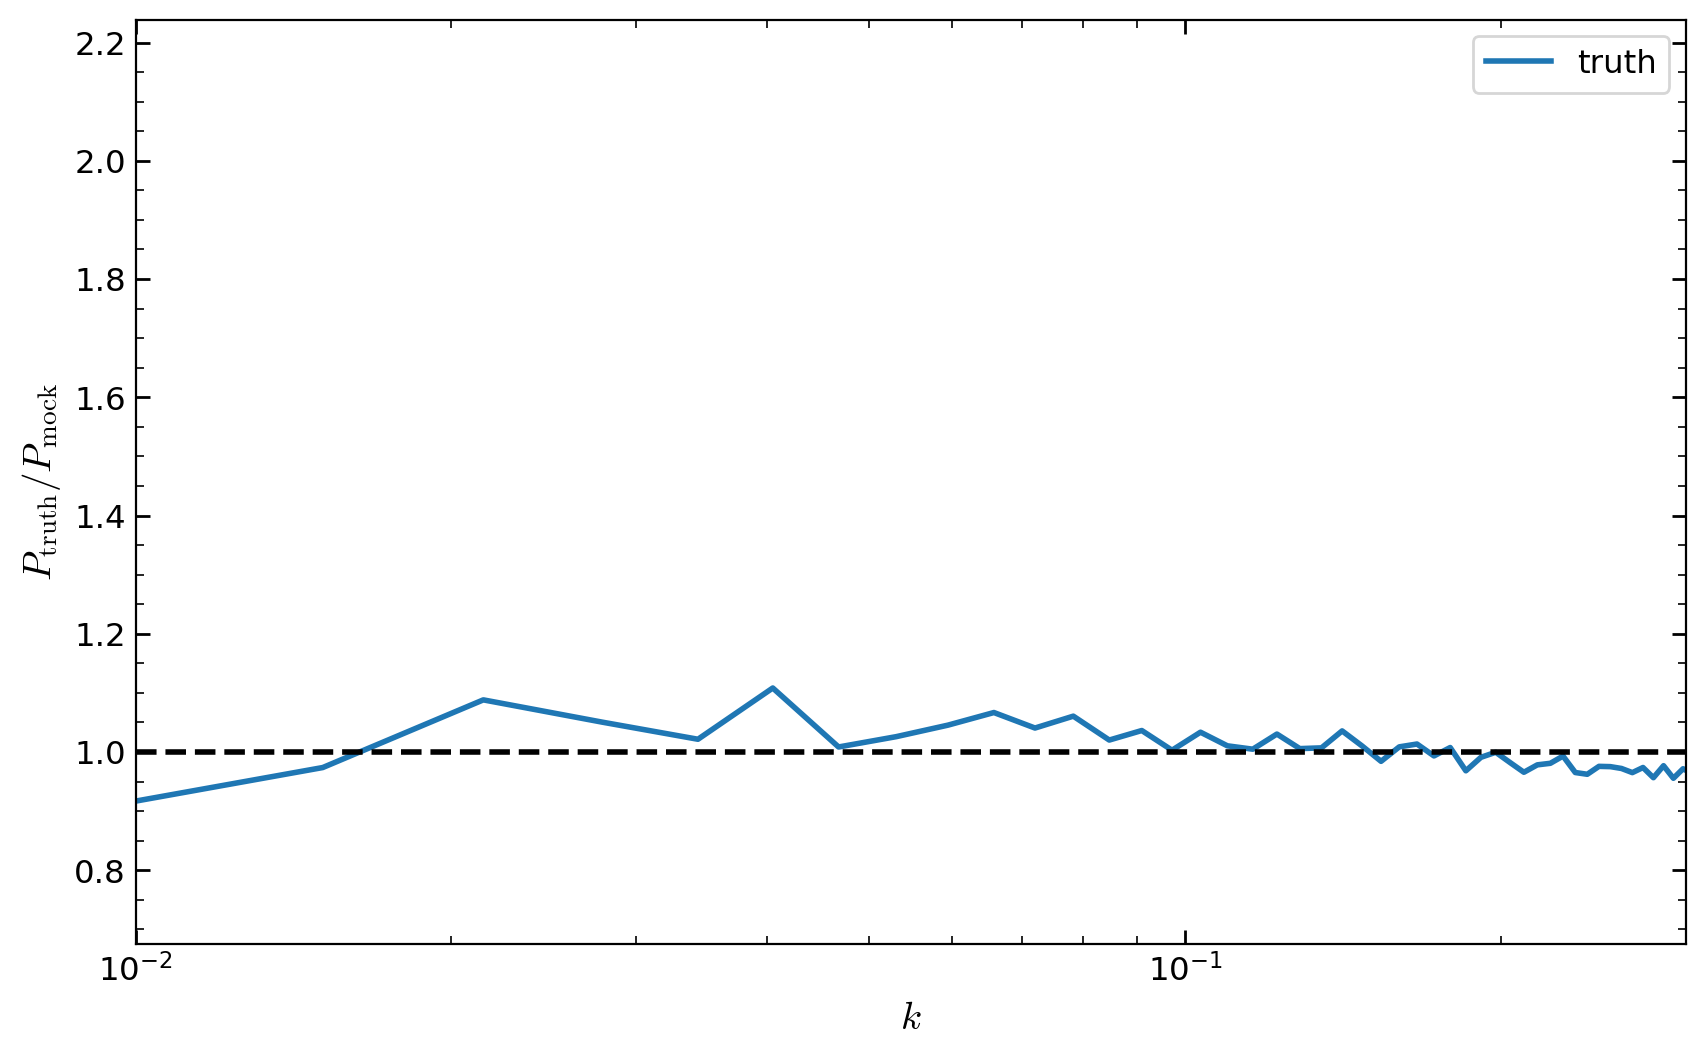

In [10]:
pl = plt
pl.figure()
pl.plot(Pk_h_truth.k3D, Pk_h_truth.Pk[:,0]/Pk_h_mock.Pk[:,0], label='truth')
pl.xscale('log')
# pl.ylim(0.8,1.2)
pl.xlim(0.01, 0.3)
pl.axhline(1.0, ls='--', color='k')
# pl.title(f'LH-ID = {test_LH_id}')
pl.xlabel(r'$k$')
pl.ylabel(r'$P_{\rm truth}/P_{\rm mock}$')
pl.legend()

[]

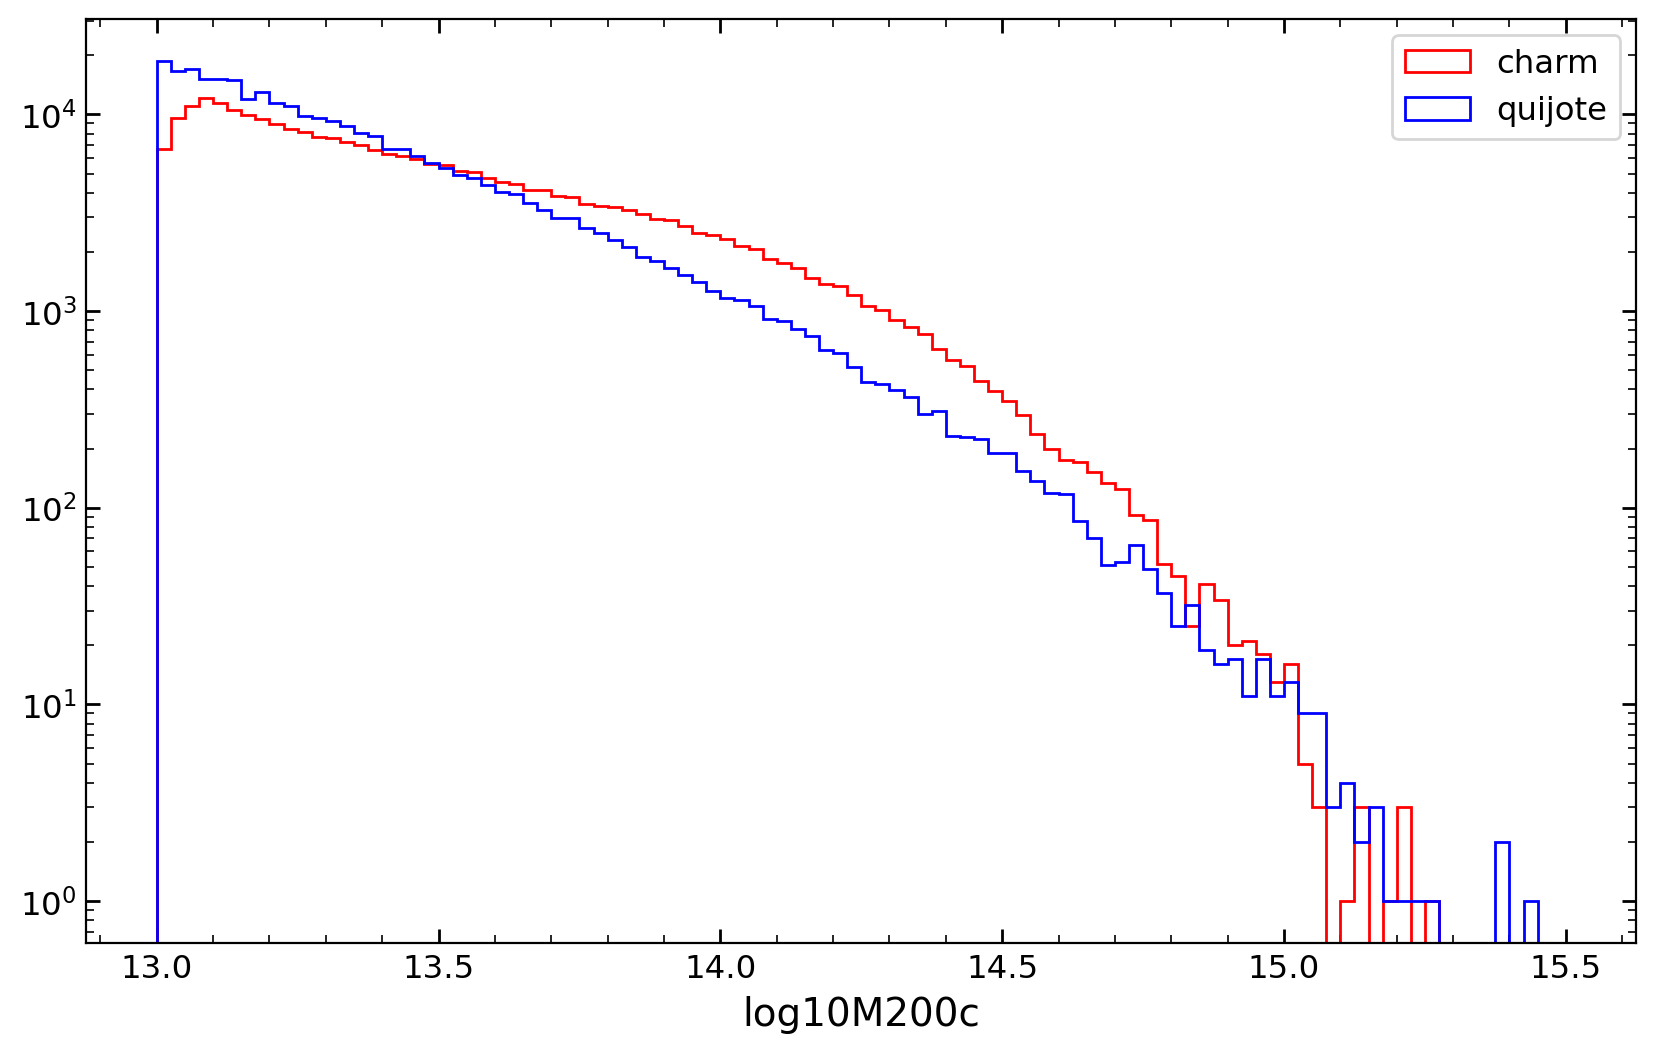

In [11]:
qmass = qmass[qmass > 13]
hmass = hmass[hmass > 13]

plt.hist(hmass, bins=100, histtype='step', color='r', label='charm', range=(13,15.5));
plt.hist(qmass, bins=100, histtype='step', color='b', label='quijote', range=(13,15.5));

plt.xlabel('log10M200c')
plt.legend()
plt.semilogy()

### Compare across lhids

In [30]:
for i in range(1,2):
    print(i)

    # Load Quijote
    snapnum = 3
    isim_fid = i
    mass_type = 'rockstar_200c'
    snap_dir_base = '/home/mattho/data/quijote/Halos/Rockstar/latin_hypercube_HR'
    snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
    rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
    with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
        lines = f.readlines()
    header = lines[0].split()
    # get the properties of the halos
    pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
    if mass_type == 'rockstar_vir':
        index_M = header.index('Mvir')                    
        mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    if mass_type == 'rockstar_200c':
        index_M = header.index('M200c')                    
        mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
    # Conform
    qmass = np.log10(mass_truth)
    mask = qmass > 13
    qmass = qmass[mask]
    qpos = pos_h_truth[mask]

    
    # Load BORG-PM
    lhid = i
    wdir = '/home/mattho/git/ltu-cmass/data/'
    cdir = wdir+f'charm_1gpch_z0.5/borgpm/L1000-N128/{lhid}'
    r = np.load(join(cdir, 'rho.npy'))
    ric = np.load(join(cdir, 'rho_z50.npy'))


    # Run charm
    from cmass.bias.charm.integrate_ltu_cmass import get_model_interface
    from cmass.utils import load_params
    run_config_name = 'config_v0.yaml'
    charm_interface = get_model_interface(run_config_name)

    cpars = load_params(i, '../params/latin_hypercube_params.txt')
    print(cpars)
    hpos, hmass = charm_interface.process_input_density(
        r,
        ric*0.5152969262698477*0.7,
        cosmology_array=np.array(cpars)
    )
    mask = hmass > 13
    hpos = hpos[mask]
    hmass = hmass[mask]

    import Pk_library as PKL
    import MAS_library as MASL

    grid = 128
    BoxSize = 1000
    MAS = 'NGP'
    mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA((qpos).astype(np.float32), mesh_truth, BoxSize, MAS)
    mesh_truth /= np.mean(mesh_truth, dtype=np.float32);  mesh_truth -= 1.0
    Pk_h_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)  
    shot_noise_g_truth = BoxSize**3/len(qpos)  

    mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    MASL.MA((hpos).astype(np.float32), mesh_mock, BoxSize, MAS)
    mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
    Pk_h_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)
    shot_noise_g_mock = BoxSize**3/len(hpos)

1


/tmp/ipykernel_350994/4059226137.py:23: RuntimeWarning: divide by zero encountered in log10
  qmass = np.log10(mass_truth)



loading bestfit model
-34.86669921875 20278

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.09 seconds

Computing power spectrum of the field...
Time to complete loop = 0.07
Time taken = 0.08 seconds


In [34]:
print(cpars)

[0.2139, 0.05557, 0.8599, 0.9785, 0.8619]


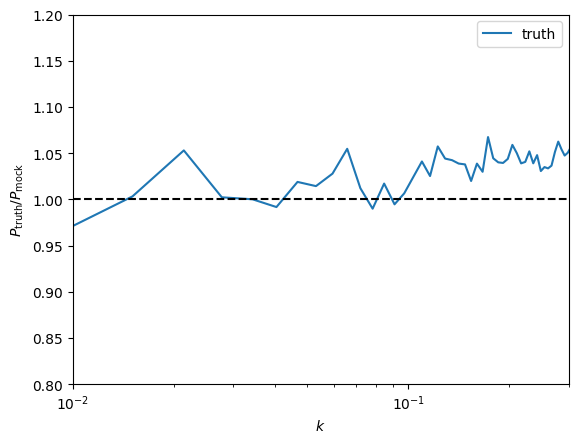

In [31]:
pl = plt
pl.figure()
pl.plot(Pk_h_truth.k3D, Pk_h_truth.Pk[:,0]/Pk_h_mock.Pk[:,0], label='truth')
pl.xscale('log')
pl.ylim(0.8,1.2)
pl.xlim(0.01, 0.3)
pl.axhline(1.0, ls='--', color='k')
# pl.title(f'LH-ID = {test_LH_id}')
pl.xlabel(r'$k$')
pl.ylabel(r'$P_{\rm truth}/P_{\rm mock}$')
pl.legend()

[]

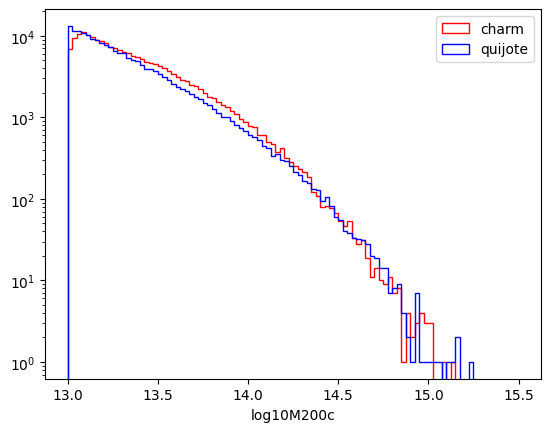

In [33]:
qmass = qmass[qmass > 13]
hmass = hmass[hmass > 13]

plt.hist(hmass, bins=100, histtype='step', color='r', label='charm', range=(13,15.5));
plt.hist(qmass, bins=100, histtype='step', color='b', label='quijote', range=(13,15.5));

plt.xlabel('log10M200c')
plt.legend()
plt.semilogy()

 ## Get 2Gpc/h working

In [6]:
lhid = 3
BoxSize=2000.0
wdir = '/home/mattho/git/ltu-cmass/data/'
cdir = wdir+f'inf_2gpch/borgpm/L2000-N256/{lhid}'
os.listdir(cdir)

r = np.load(join(cdir, 'rho.npy'))
ric = np.load(join(cdir, 'rho_z50.npy'))

In [54]:
r.shape

(256, 256, 256)

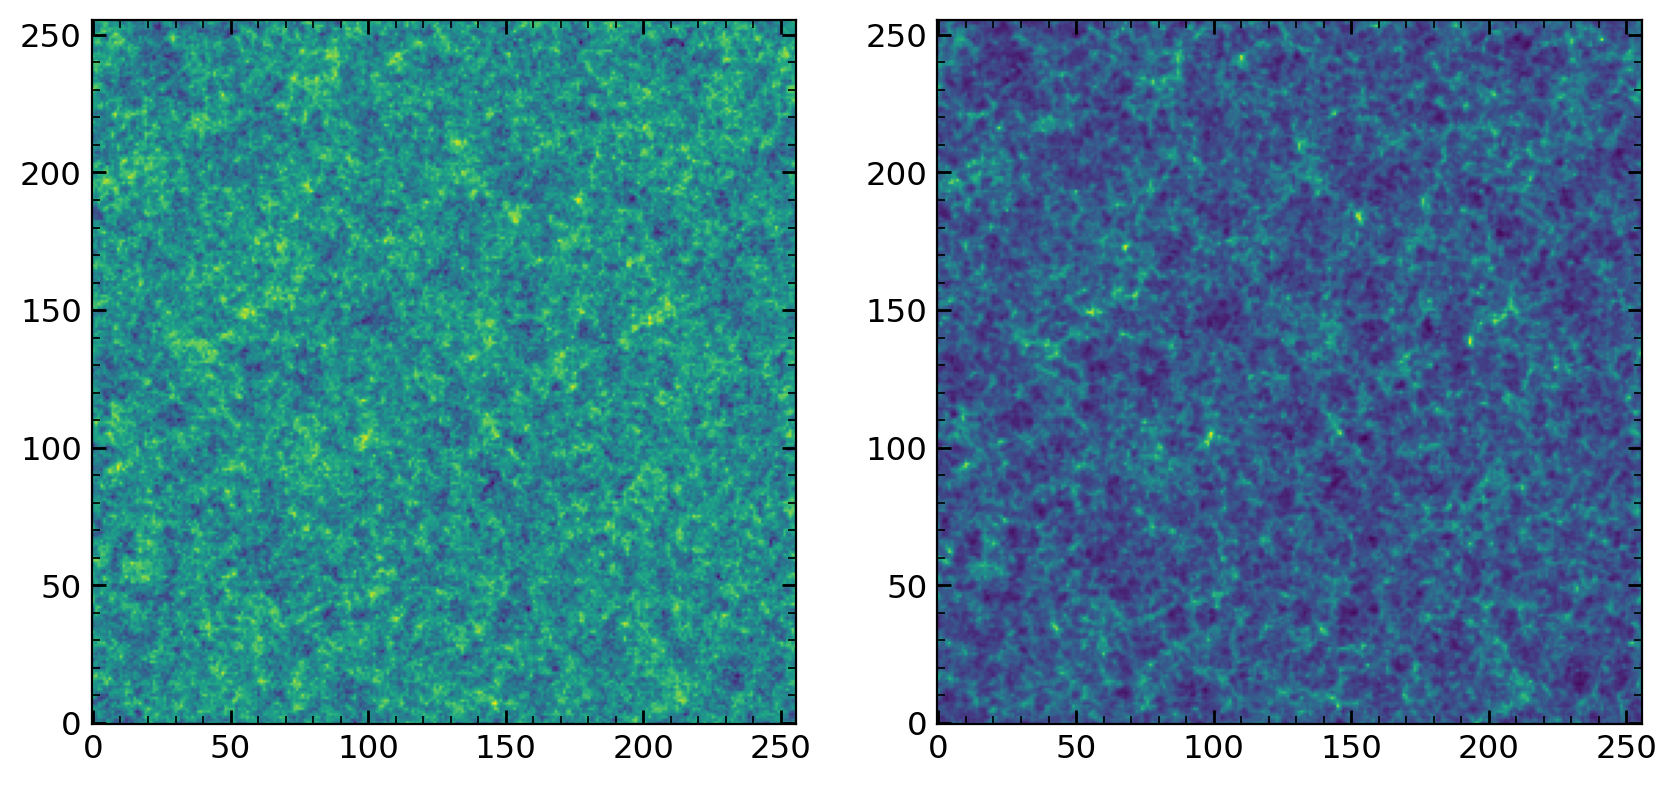

In [55]:
f, axs = plt.subplots(1,2)
axs[0].imshow(slice_box(ric, i, di))
axs[1].imshow(slice_box(r, i, di))

In [56]:
from colossus.cosmology import cosmology as csm
from cmass.utils import cosmo_to_colossus
cpars = [0.3271, 0.06875, 0.6313, 0.8135, 0.8939]

# cosmo = cosmo_to_astropy(cpars)
# cosmo = csm.fromAstropy(
#     cosmo, sigma8=cpars[4], ns=cpars[3], cosmo_name='myCosmo', Tcmb0 = 2.7255)
cosmo = cosmo_to_colossus(cpars)
corr = cosmo.growthFactorUnnormalized(z=99)
corr /= cosmo.growthFactorUnnormalized(z=50)
print(corr)

0.5152969262698477


In [57]:
# Run charm

from cmass.bias.charm.integrate_ltu_cmass import get_model_interface
run_config_name = 'config_v0.yaml'
charm_interface = get_model_interface(run_config_name)

cpars = [0.3271, 0.06875, 0.6313, 0.8135, 0.8939]
hpos, hmass = charm_interface.process_input_density(
    r,
    ric*0.5152969262698477*0.7,
    cosmology_array=np.array(cpars)
)
mask = hmass > 13
hpos = hpos[mask]
hmass = hmass[mask]


loading bestfit model
-34.86669921875 20278
torch.Size([1, 1, 3, 264, 264, 264]) torch.Size([1, 16777216, 3]) torch.Size([1, 16777216, 5]) 1 1 1 1 1


ValueError: Invalid input size

In [67]:
import numpy as np
def ceildiv(a, b):
    return -(a // -b)

In [71]:
n = 128
C = 4
Np = n + 2*C
Lp = r.shape[0] + 2*C

nb = ceildiv(r.shape[0], n)

rp = np.pad(r, C, mode='wrap')
ricp = np.pad(ric, C, mode='wrap')


def batch_cube(x, n, Np):
    batches = []
    for i in range(nb):
        for j in range(nb):
            for k in range(nb):
                batches.append(x[i*n:i*n+Np, j*n:j*n+Np, k*n:k*n+Np])
    return np.stack(batches, axis=0)

rb = batch_cube(r, n, n)
rb_pad = batch_cube(rp, n, Np)
ricb = batch_cube(ric, n, n)
ricb_pad = batch_cube(ricp, n, Np)

rb.shape, rb_pad.shape

((8, 128, 128, 128), (8, 136, 136, 136))

In [72]:
from cmass.bias.charm.integrate_ltu_cmass import get_model_interface
run_config_name = 'config_v0.yaml'
charm_interface = get_model_interface(run_config_name)

cpars = [0.3271, 0.06875, 0.6313, 0.8135, 0.8939]

hposs, hmasss = [], []
for i in range(len(rb)):
    hpos, hmass = charm_interface.process_input_density(
        rho_m_zg = rb[i],
        rho_m_zIC = ricb[i]*0.5152969262698477*0.7,
        df_test_pad_zg = rb_pad[i],
        df_test_pad_zIC = ricb_pad[i]*0.5152969262698477*0.7,
        cosmology_array=np.array(cpars),
        BoxSize=1000
    )
    mask = hmass > 13
    hposs.append(hpos[mask])
    hmasss.append(hmass[mask])


loading bestfit model
-34.86669921875 20278


/home/mattho/git/ltu-cmass/cmass/bias/charm/integrate_ltu_cmass.py:362: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1


/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)
torch.Size([1, 1, 3, 136, 136, 136]) torch.Size([1, 2097152, 3]) torch.Size([1, 2097152, 5]) 1 1 1 1 1
(2097152,)


In [73]:
l=0
L = 1000
for i in range(nb):
    for j in range(nb):
        for k in range(nb):
            hposs[l] = hposs[l] + np.array([i*L, j*L, k*L])
            l += 1

In [74]:
hposs = np.concatenate(hposs)
hmasss = np.concatenate(hmasss)

In [80]:
voxL = 1000/128
hposs += np.random.uniform(
    low=-voxL/2, high=voxL/2, size=hposs.shape
)

(0.0, 2000.0, 0.0, 2000.0)

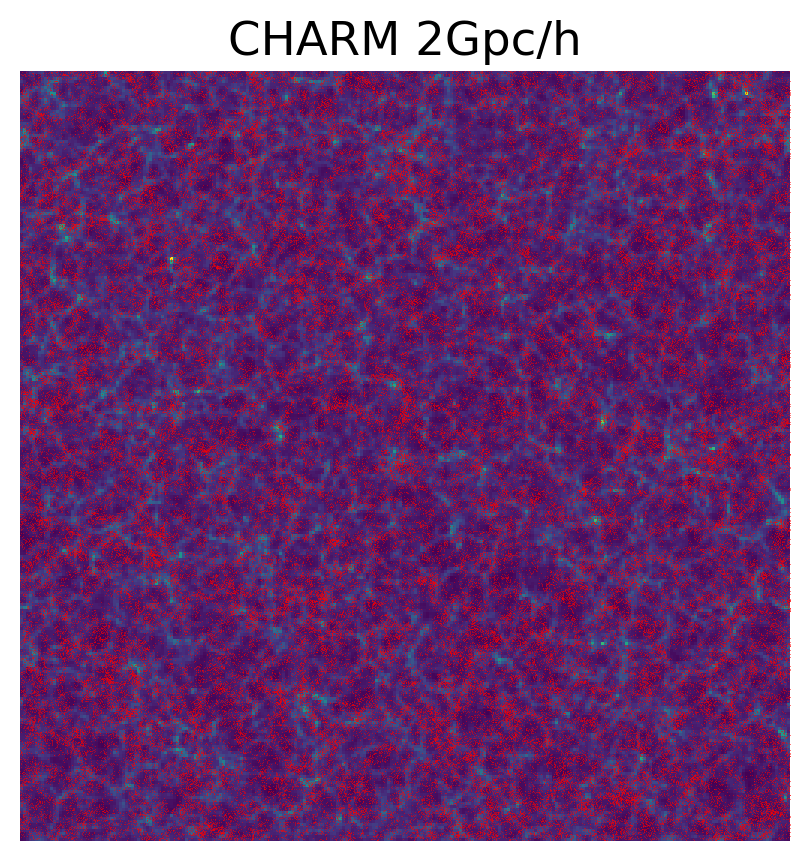

In [94]:
f, ax = plt.subplots(1,1, figsize=(5,5))
i=100
di=10
ax.imshow(slice_box(r, i, di), extent=[0,2000]*2, origin='lower')
_p = slice_cat(hposs, i, di)
ax.plot(_p[:,1], _p[:,2], 'r,', alpha=0.5)
ax.set_title('CHARM 2Gpc/h')
ax.axis('off')


In [7]:

twodir = join(wdir, 'inf_2gpch/borgpm/L2000-N256/3')

r = np.load(join(twodir, 'rho.npy'))
hpos = np.load(join(twodir, 'halo_pos.npy'))
hmass = np.load(join(twodir, 'halo_mass.npy'))

In [13]:
hpos.max()

1999.9995

## BORG tests

In [53]:
lhid=3
wdir = f'/home/mattho/git/ltu-cmass/data/test/borg2lpt/L1000-N128/{lhid}'
os.listdir(wdir)

rho = np.load(join(wdir, 'rho.npy')).astype(np.float32)
fvel = np.load(join(wdir, 'fvel.npy')).astype(np.float32)
rho50 = np.load(join(wdir, 'rho_transfer.npy')).astype(np.float32)

In [54]:
# Load FastPM

import pickle

lhid=3
fdir = '/home/mattho/git/ltu-cmass/data/scratch/fastpm'
filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=99_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rhoc_IC = d['density_cic_unpad_combined']

filename = join(fdir, f'LH{lhid}_density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rhoc = d['density_cic_unpad_combined']
print(rhoc_IC.shape, rhoc.shape)

(128, 128, 128) (128, 128, 128)


In [55]:
# Load quijote

qdir = '/home/mattho/data/quijote/density_field/latin_hypercube'
rhoq = np.load(join(qdir, str(lhid), 'df_m_128_z=0.npy'))

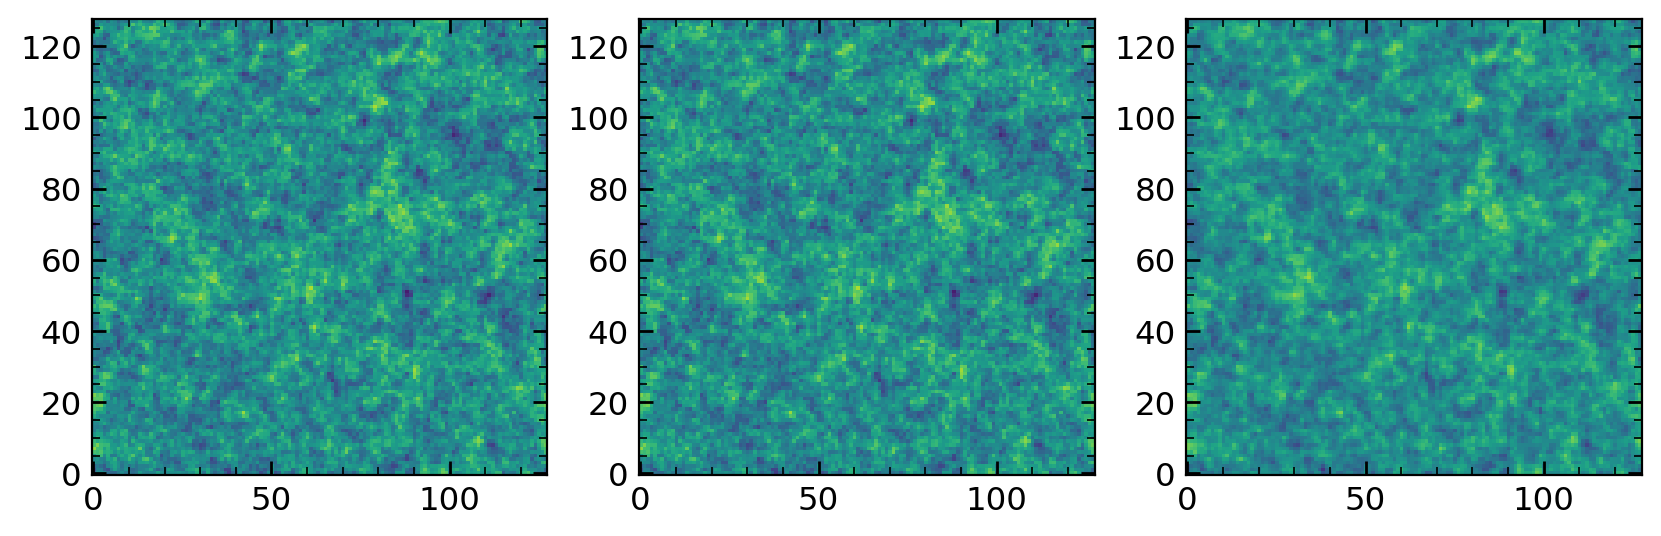

In [56]:
f, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(np.mean(rho50a, axis=0), vmin=-0.01, vmax=0.01)
axs[1].imshow(np.mean(rho50, axis=0), vmin=-0.01, vmax=0.01)
axs[2].imshow(np.mean(rhoc_IC, axis=0), vmin=-0.01, vmax=0.01)

Text(0.5, 1.0, 'rhoc_IC')

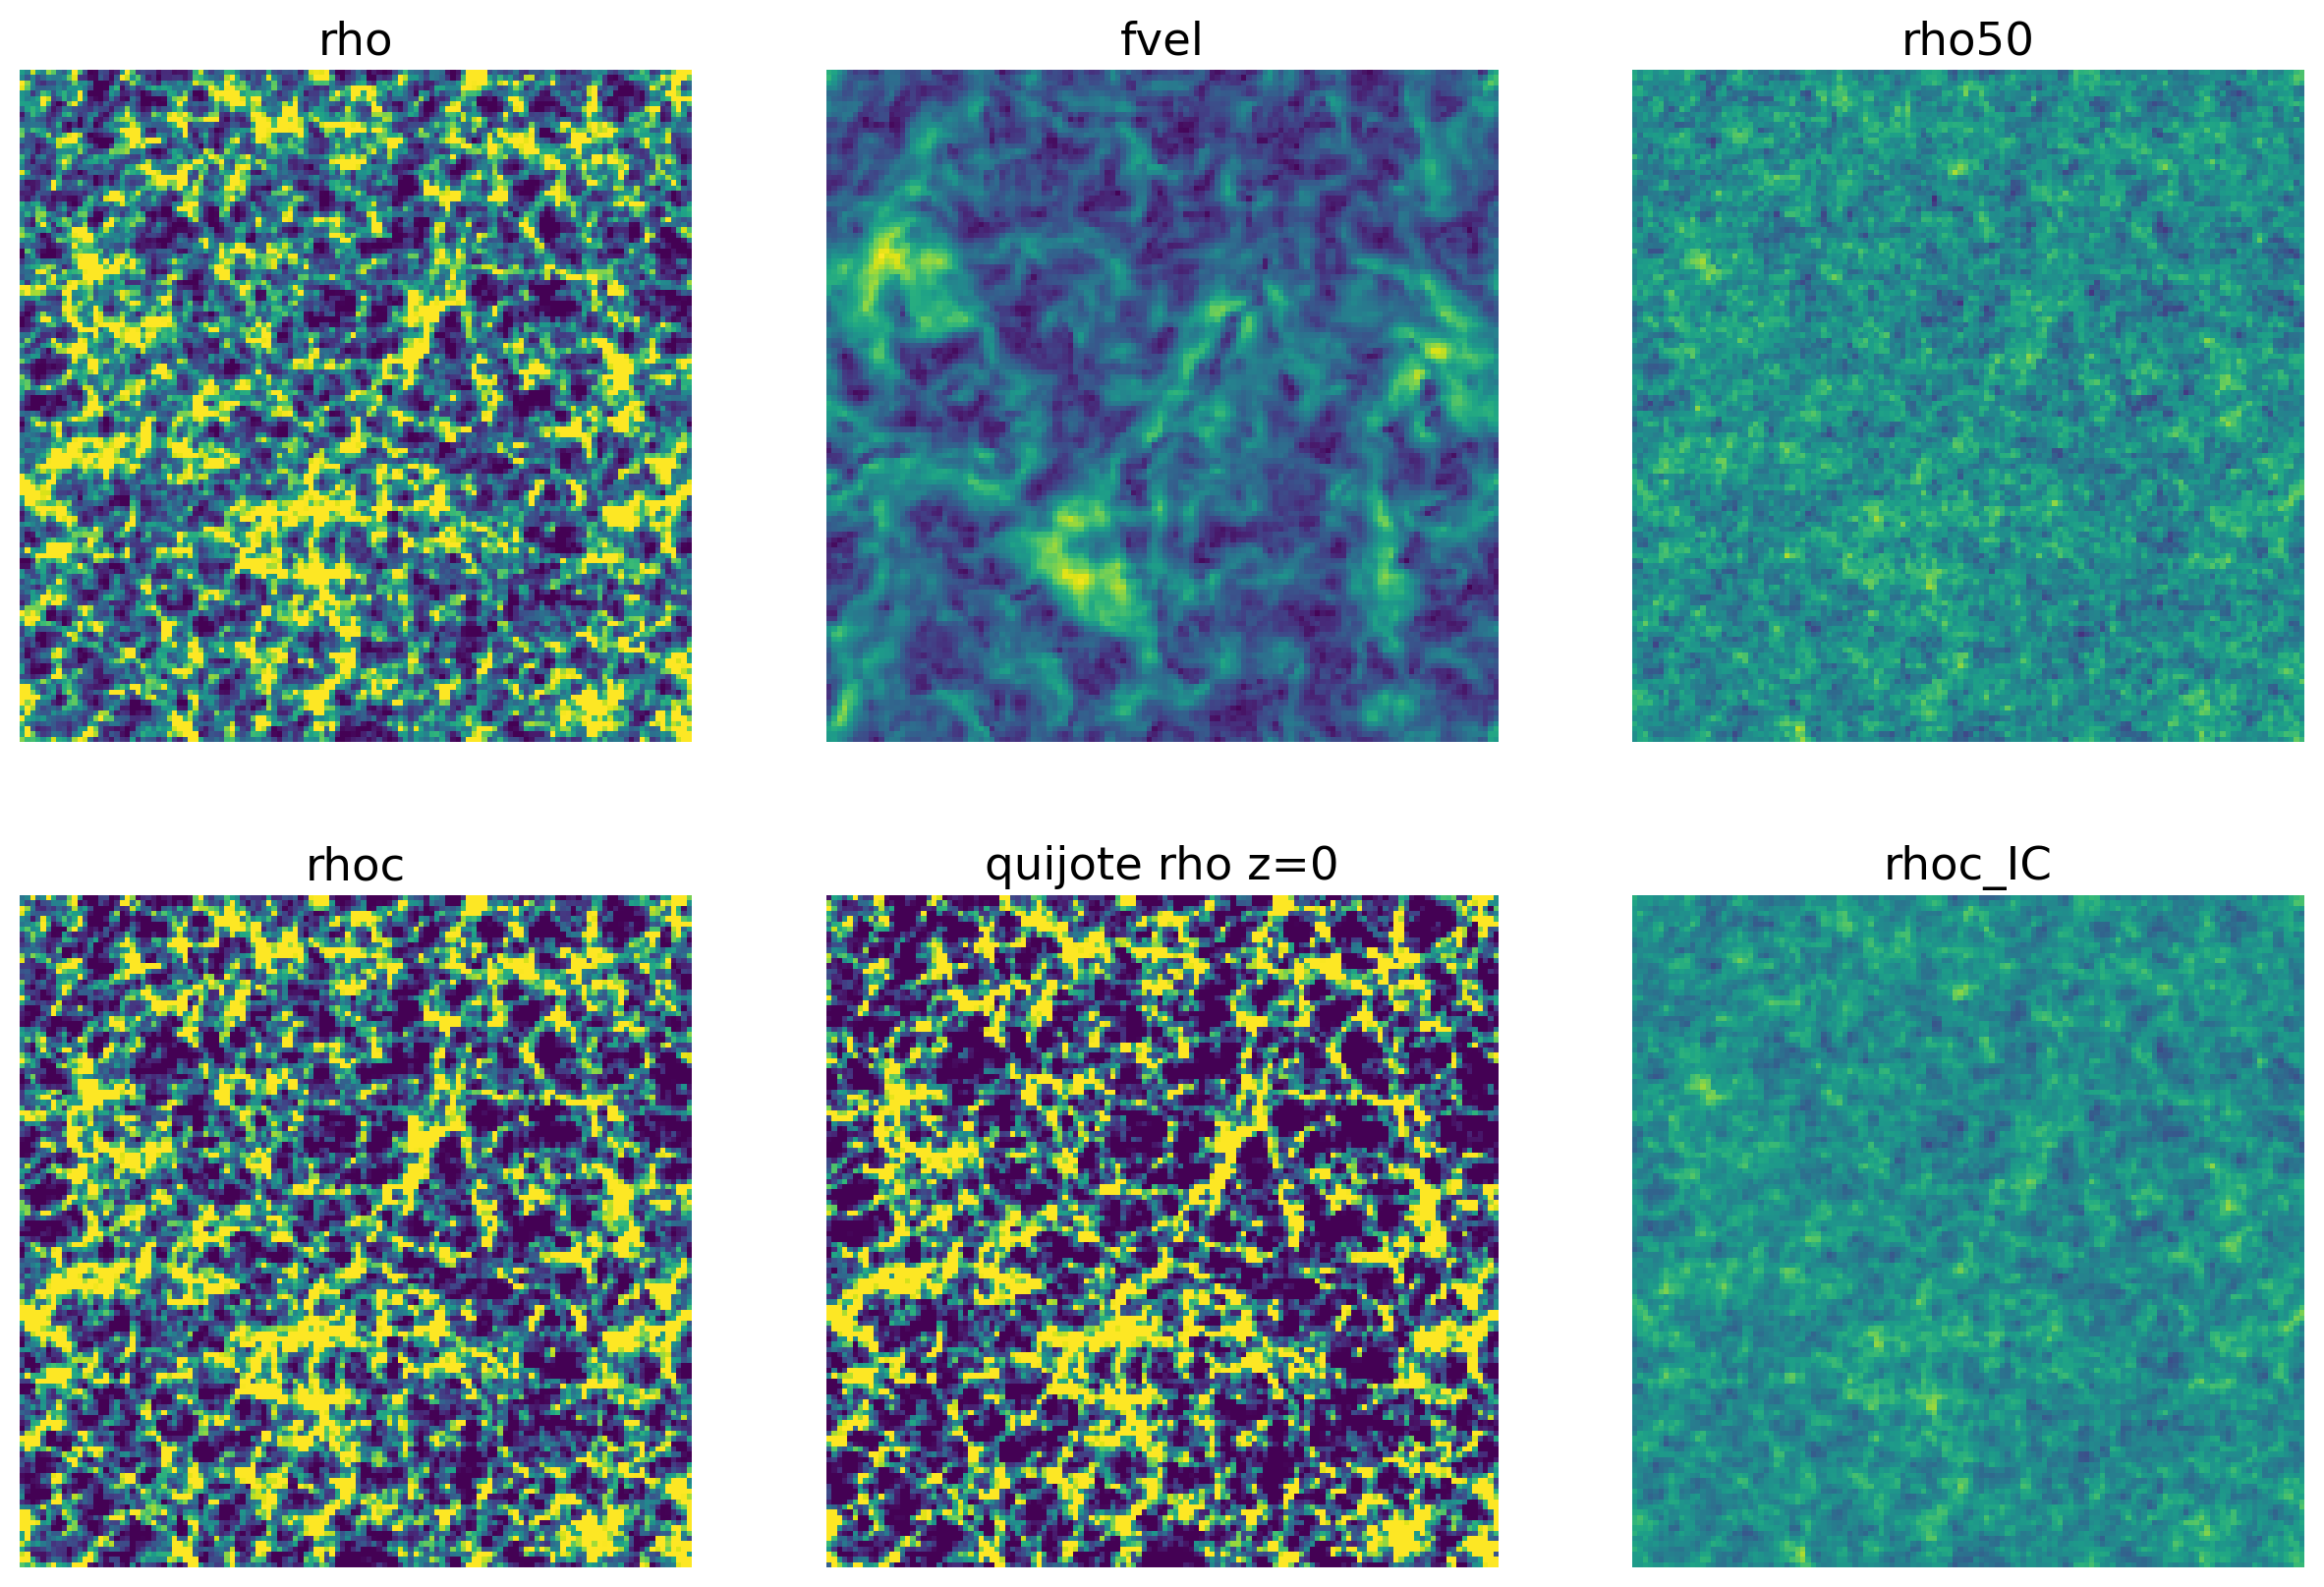

In [57]:
f, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.flatten()

ax = axs[0]
ax.imshow(np.mean(rho[60:65], axis=0), vmin=-0.5, vmax=0.5)
ax.axis('off')
ax.set_title('rho')

ax = axs[1]
ax.imshow(np.linalg.norm(fvel[60], axis=-1))
ax.axis('off')
ax.set_title('fvel')

ax = axs[2]
# ax.imshow(np.mean(rho50[180:195], axis=0), vmin=-0.05, vmax=0.05)
ax.imshow(np.mean(rho50[60:65], axis=0), vmin=-0.05, vmax=0.05)
ax.axis('off')
ax.set_title('rho50')

ax = axs[3]
ax.imshow(np.mean(rhoc[60:65], axis=0), vmin=-0.5, vmax=0.5)
ax.axis('off')
ax.set_title('rhoc')

ax = axs[4]
ax.imshow(np.mean(rhoq[60:65], axis=0), vmin=-0.5, vmax=0.5)
ax.axis('off')
ax.set_title('quijote rho z=0')

ax = axs[5]
ax.imshow(np.mean(rhoc_IC[60:65], axis=0), vmin=-0.05, vmax=0.05)
ax.axis('off')
ax.set_title('rhoc_IC')

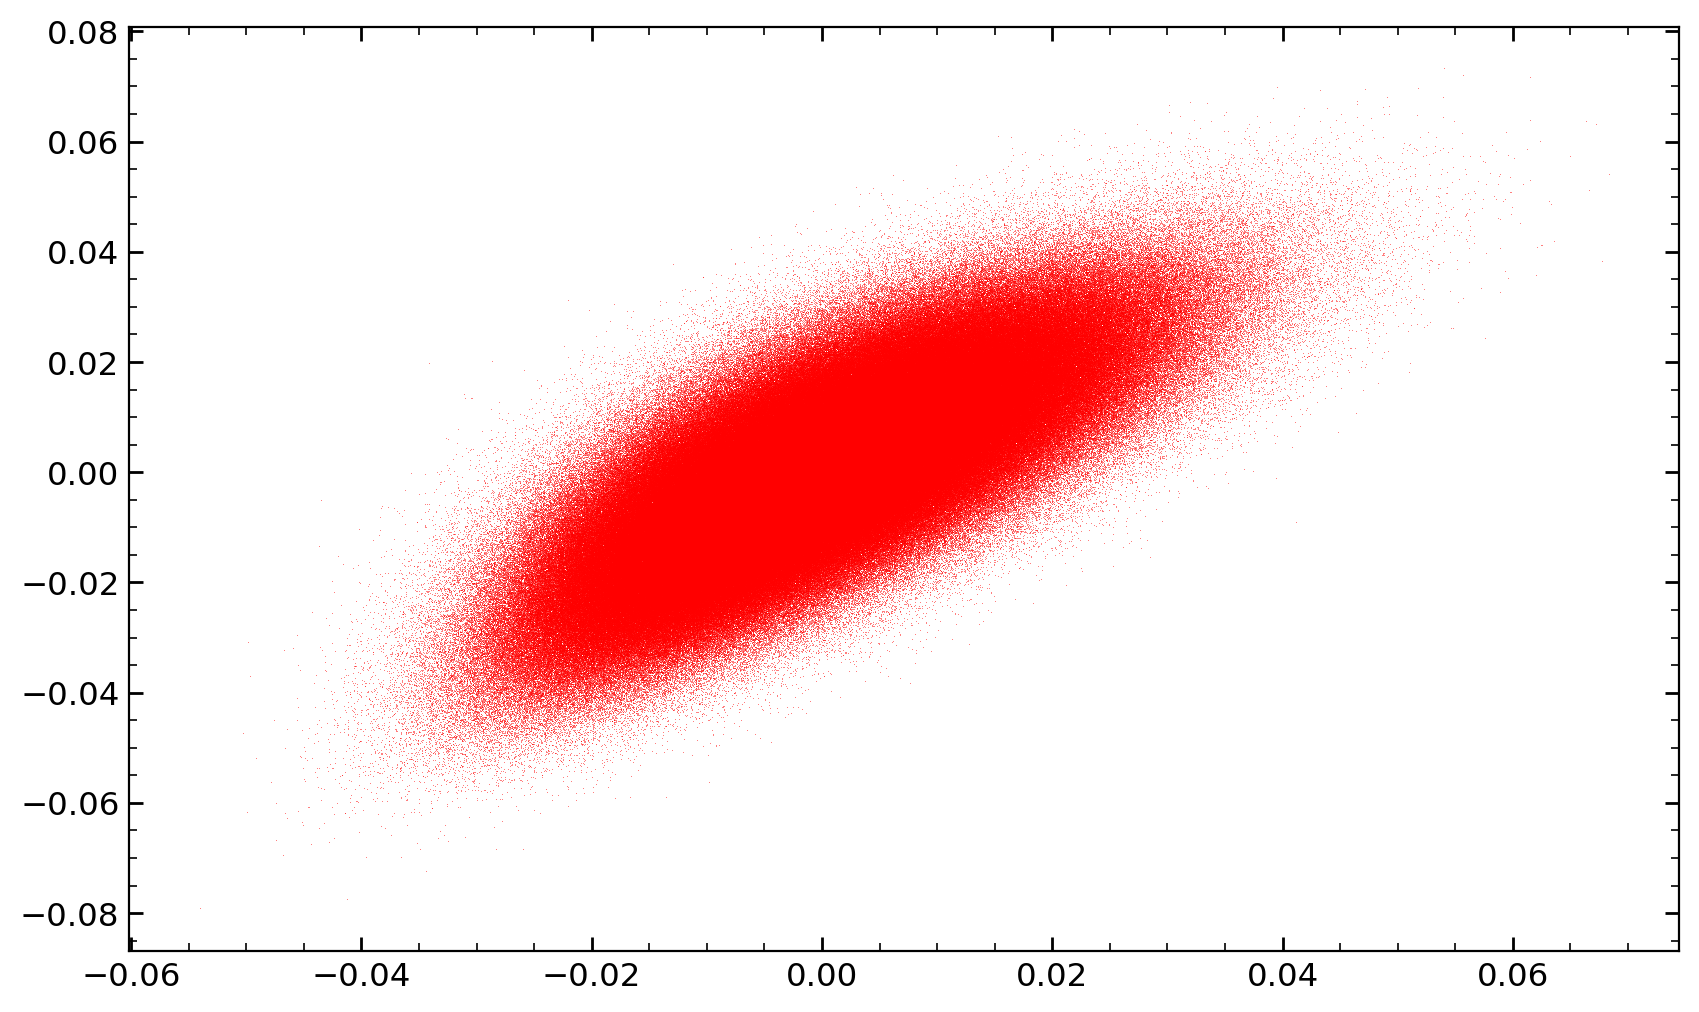

In [58]:
plt.plot(rhoc_IC.flatten(), rho50.flatten(), 'r,', alpha=0.5);
# plt.plot(rhoc.flatten(), rho.flatten(), 'r,', alpha=0.5);
# plt.hist(rhoc.flatten(), bins=100, histtype='step', color='r', label='fastpm')
# plt.hist(rho.flatten(), bins=100, histtype='step', color='b', label='borg');


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.05
Time taken = 0.07 seconds


Text(0, 0.5, 'XPk')

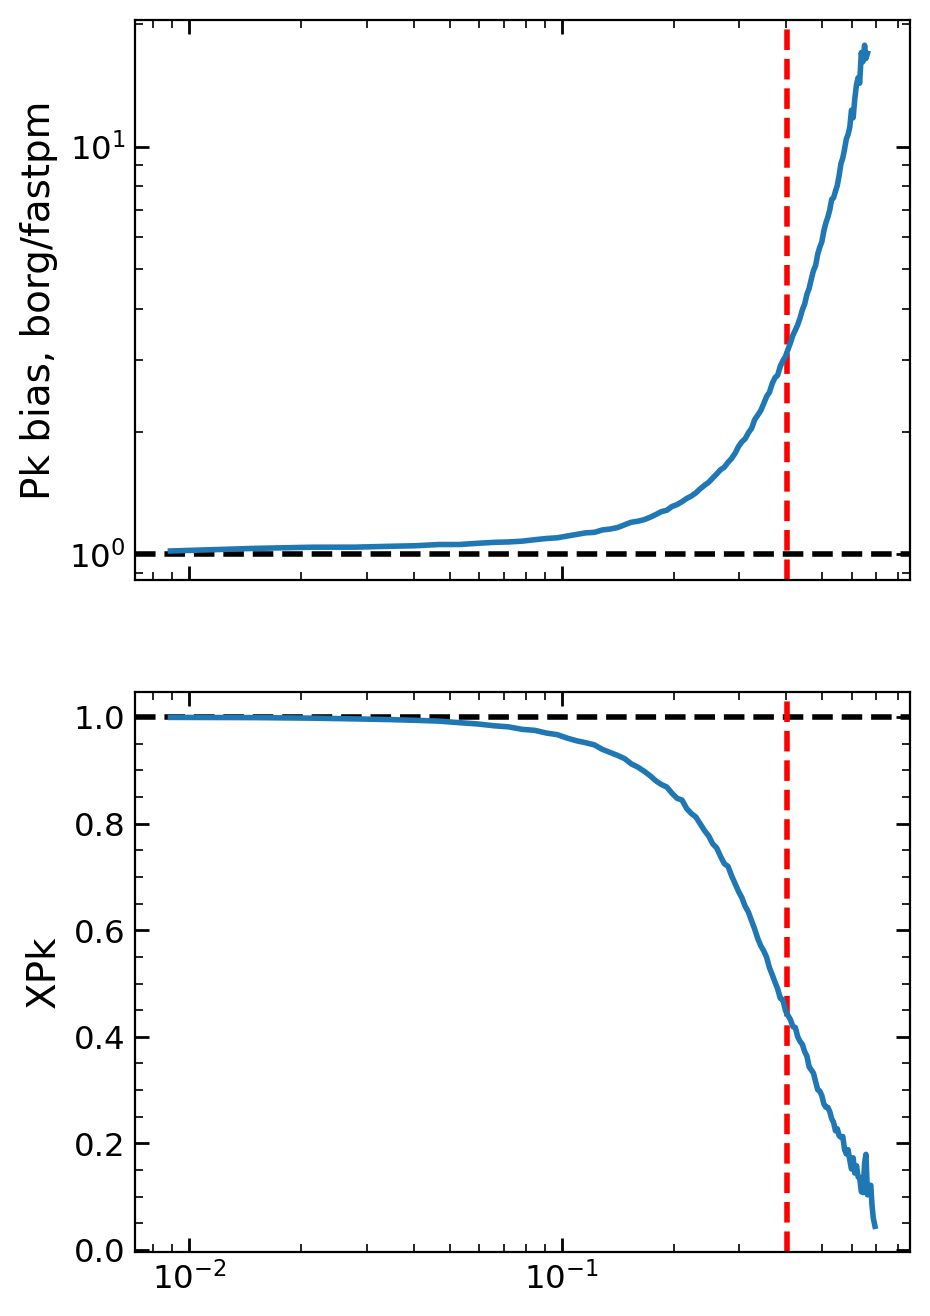

In [59]:
import Pk_library as PKL
Pk = PKL.XPk([rho50, rhoc_IC],
             1000, 0, MAS=['CIC','CIC'], threads=1)
nyq =  2*np.pi/1000*(128/2)

f, axs = plt.subplots(2, 1, figsize=(5,8), sharex=True)

k, dpk= Pk.k3D, Pk.Pk[:,0,0]/Pk.Pk[:,0,1]
xpk = Pk.XPk[:,0,0]/np.sqrt(Pk.Pk[:,0,0]*Pk.Pk[:,0,1])

ax = axs[0]
ax.loglog()
ax.axhline(1, color='k', ls='--')
ax.axvline(nyq, color='r', ls='--')
ax.plot(k[:-5], dpk[:-5], label='Pk')
ax.set_ylabel('Pk bias, borg/fastpm')

ax = axs[1]
ax.semilogx()
ax.axhline(1, color='k', ls='--')
ax.axvline(nyq, color='r', ls='--')
ax.plot(k, xpk, label='XPk')
ax.set_ylabel('XPk')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


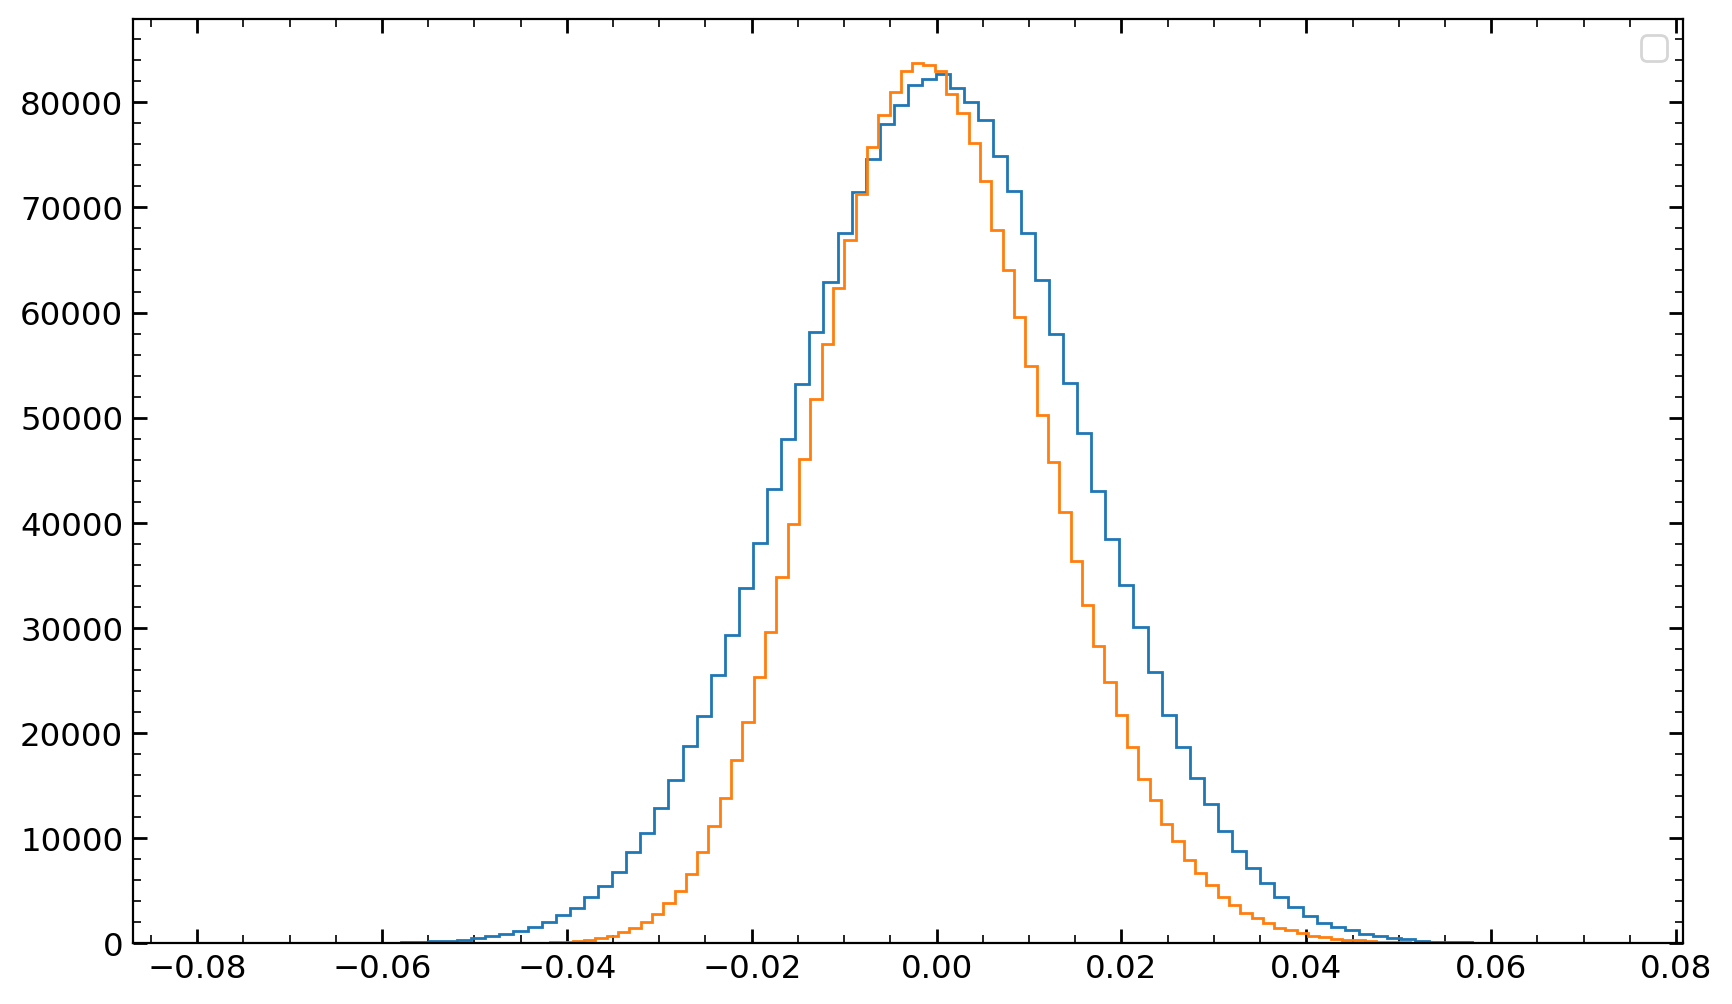

In [60]:
plt.hist(rho50.flatten(), bins=100, histtype='step')
plt.hist(rhoc_IC.flatten(), bins=100, histtype='step');

# plt.hist(rho.flatten(), bins=100, histtype='step', color='r', label='borg')
# plt.hist(rhoc.flatten(), bins=100, histtype='step', color='b', label='fastpm')
plt.legend();

## Scratch test

In [4]:
wdir = '/home/mattho/git/ltu-cmass/data/2gpch_0704/borgpm/L2000-N256/10'
os.listdir(wdir)

rho = np.load(join(wdir, 'rho.npy'))
fvel = np.load(join(wdir, 'fvel.npy'))
rho_transfer = np.load(join(wdir, 'rho_transfer.npy'))

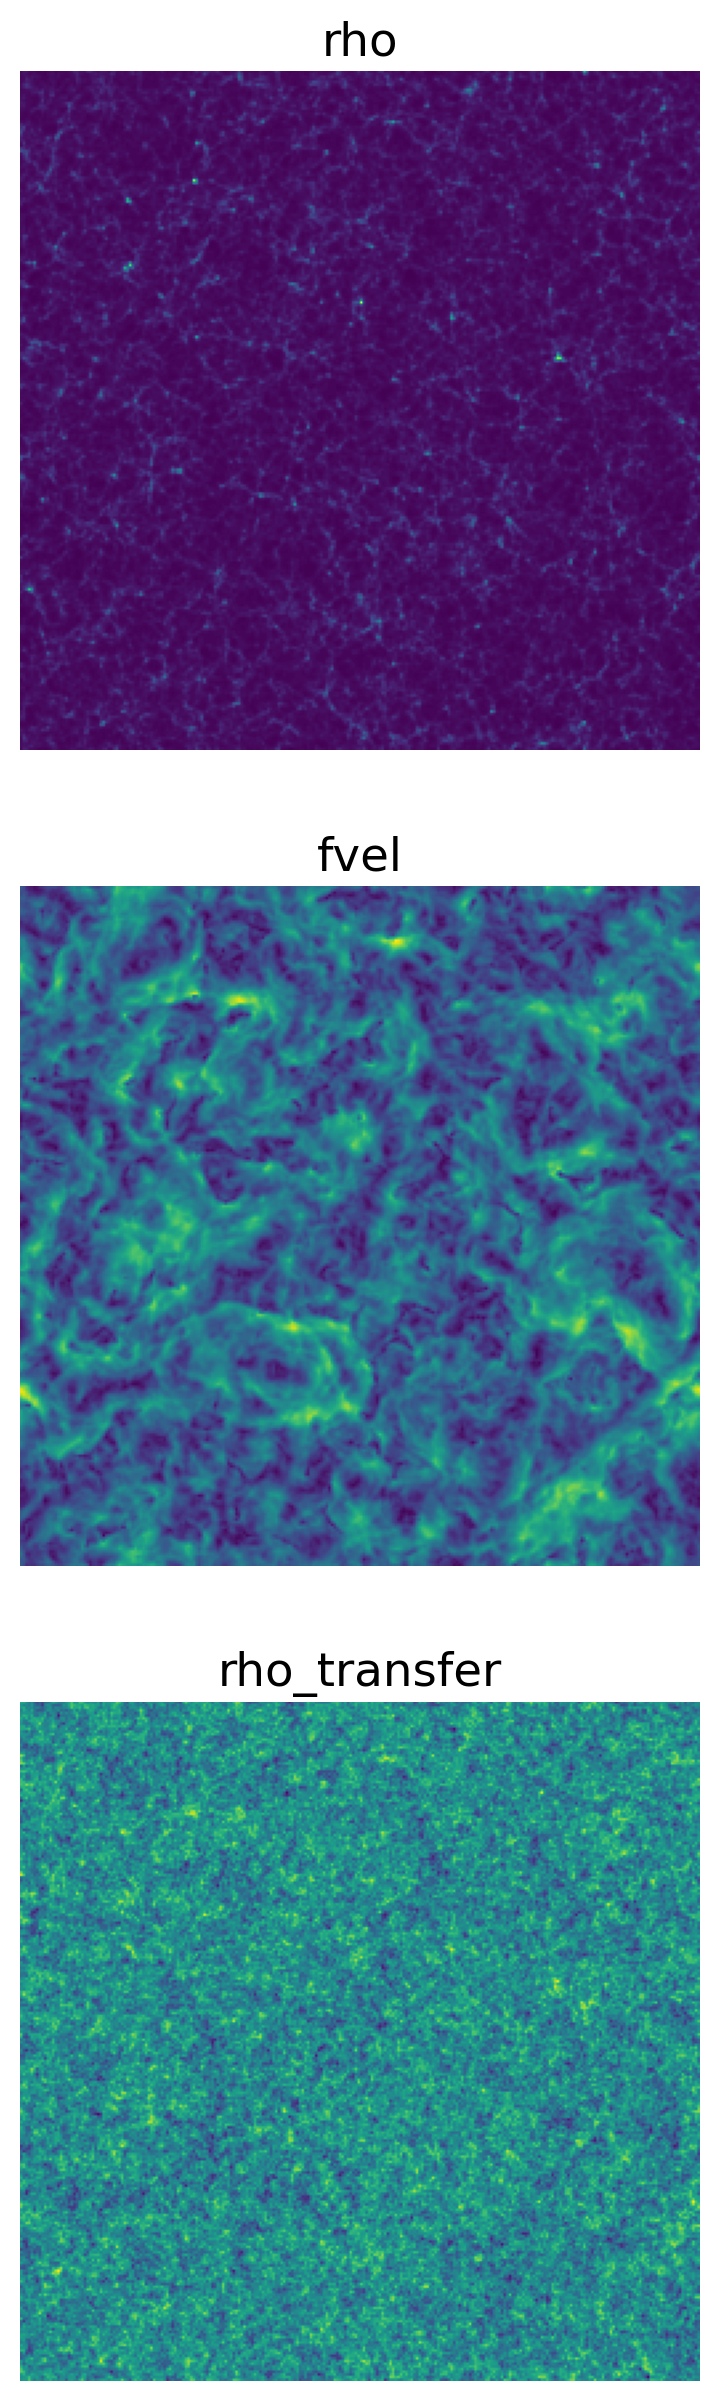

In [5]:
i = 100
f, axs = plt.subplots(3,1,figsize=(5,15))
axs[0].imshow(rho[100])
axs[0].set_title('rho')
axs[1].imshow(np.linalg.norm(fvel[100], axis=-1))
axs[1].set_title('fvel')
axs[2].imshow(rho_transfer[100])
axs[2].set_title('rho_transfer')
for ax in axs:
    ax.axis('off')

In [34]:
# import numpy as np
# import MAS_library as MASL

# # number of particles
# Np = 128**3

# # density field parameters
# grid    = 128    #the 3D field will have grid x grid x grid voxels
# BoxSize = 1000.0 #Mpc/h ; size of box
# MAS     = 'CIC'  #mass-assigment scheme
# verbose = True   #print information on progress

# # particle positions in 3D
# pos = np.random.random((Np,3)).astype(np.float32)*BoxSize

# # define 3D density field
# delta = np.zeros((grid,grid,grid), dtype=np.float32)

# # construct 3D density field
# MASL.MA(pos, delta, BoxSize, MAS, value=2, verbose=verbose)

# # at this point, delta contains the effective number of particles in each voxel
# # now compute overdensity and density constrast
# delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

In [11]:
np.arange(20).reshape(10,2).flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])